In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf

# All references used in this project:

[Changing tile size on hist](https://stackoverflow.com/questions/46188580/pandas-dataframe-hist-change-title-size-on-subplot/46189639#46189639)

[Correlation Heatmap SNS](https://stackoverflow.com/questions/39409866/correlation-heatmap)

[Column Transformer](https://stackoverflow.com/questions/54345667/onehotencoder-categorical-features-depreciated-how-to-transform-specific-column)

[Object to Datetime](https://stackoverflow.com/questions/38333954/converting-object-to-datetime-format-in-python)

[Drop Rows/Columns on a Dataframe](https://chrisalbon.com/python/data_wrangling/pandas_dropping_column_and_rows/)

[Seaborn Plotting](https://seaborn.pydata.org/index.html)

[Custom X ticks for a SNS Plot](https://stackoverflow.com/questions/43727278/how-to-set-readable-xticks-in-seaborns-facetgrid)

[Fix heatmap Plot](https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot)

[Poisson Regression Model](https://towardsdatascience.com/an-illustrated-guide-to-the-poisson-regression-model-50cccba15958)

[Negative Binomial Regression Model](https://towardsdatascience.com/negative-binomial-regression-f99031bb25b4)

In [2]:
features_test = pd.read_csv('dengue_features_test.csv')
features_train = pd.read_csv('dengue_features_train.csv')
labels_train = pd.read_csv('dengue_labels_train.csv')

#### Looking at the data, and how it is labeled, I must apply Supervised Learning. For now I'll stick to logistic regression supervised learning. I might change my mind later since it might not be a linear model.

In [3]:
features_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416 entries, 0 to 415
Data columns (total 24 columns):
city                                     416 non-null object
year                                     416 non-null int64
weekofyear                               416 non-null int64
week_start_date                          416 non-null object
ndvi_ne                                  373 non-null float64
ndvi_nw                                  405 non-null float64
ndvi_se                                  415 non-null float64
ndvi_sw                                  415 non-null float64
precipitation_amt_mm                     414 non-null float64
reanalysis_air_temp_k                    414 non-null float64
reanalysis_avg_temp_k                    414 non-null float64
reanalysis_dew_point_temp_k              414 non-null float64
reanalysis_max_air_temp_k                414 non-null float64
reanalysis_min_air_temp_k                414 non-null float64
reanalysis_precip_amt_kg_per_m2  

In [4]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 24 columns):
city                                     1456 non-null object
year                                     1456 non-null int64
weekofyear                               1456 non-null int64
week_start_date                          1456 non-null object
ndvi_ne                                  1262 non-null float64
ndvi_nw                                  1404 non-null float64
ndvi_se                                  1434 non-null float64
ndvi_sw                                  1434 non-null float64
precipitation_amt_mm                     1443 non-null float64
reanalysis_air_temp_k                    1446 non-null float64
reanalysis_avg_temp_k                    1446 non-null float64
reanalysis_dew_point_temp_k              1446 non-null float64
reanalysis_max_air_temp_k                1446 non-null float64
reanalysis_min_air_temp_k                1446 non-null float64
reanalysis_precip

In [5]:
labels_train.describe()

,year,weekofyear,total_cases
count,1456.000000,1456.000000,1456.000000
mean,2001.031593,26.503434,24.675137
std,5.408314,15.019437,43.596000
min,1990.000000,1.000000,0.000000
25%,1997.000000,13.750000,5.000000
50%,2002.000000,26.500000,12.000000
75%,2005.000000,39.250000,28.000000
max,2010.000000,53.000000,461.000000


In [6]:
labels_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 4 columns):
city           1456 non-null object
year           1456 non-null int64
weekofyear     1456 non-null int64
total_cases    1456 non-null int64
dtypes: int64(3), object(1)
memory usage: 45.6+ KB


In [7]:
#Contains all of the train related data (with their total cases)
train_concat = pd.concat([features_train, labels_train['total_cases']], sort=False, axis=1)

train_concat_copy = train_concat.copy()
#Filling with nans the coppied one
train_concat_copy.fillna(method='ffill', inplace=True)

train_concat_copy['set_type']='train'

features_test_copy = features_test.copy()

features_test_copy['set_type'] = 'test'

all_data = train_concat_copy.append(features_test_copy, sort=False)

all_data['week_start_date'] = pd.to_datetime(all_data['week_start_date'])

all_data['city']=all_data['city'].astype('category')

#putting all the data inside of a single dataframe

#imputer = SimpleImputer(missing_values =np.nan, strategy='mean')

#nan_labels= list(all_train.columns[4:-1])
#imputer=imputer.fit(all_train[nan_labels])

#all_train[nan_labels] = imputer.transform(all_train[nan_labels].values)

#filling missing data with means

In [8]:
train_concat.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [9]:
all_data.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,set_type
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4.0,train
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5.0,train
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4.0,train
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3.0,train
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6.0,train


In [10]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1872 entries, 0 to 415
Data columns (total 26 columns):
city                                     1872 non-null category
year                                     1872 non-null int64
weekofyear                               1872 non-null int64
week_start_date                          1872 non-null datetime64[ns]
ndvi_ne                                  1829 non-null float64
ndvi_nw                                  1861 non-null float64
ndvi_se                                  1871 non-null float64
ndvi_sw                                  1871 non-null float64
precipitation_amt_mm                     1870 non-null float64
reanalysis_air_temp_k                    1870 non-null float64
reanalysis_avg_temp_k                    1870 non-null float64
reanalysis_dew_point_temp_k              1870 non-null float64
reanalysis_max_air_temp_k                1870 non-null float64
reanalysis_min_air_temp_k                1870 non-null float64
reanalys

In [11]:
#scaling some of the data for better performance
standardScaler = StandardScaler()

scale_cols = ['precipitation_amt_mm', 'reanalysis_sat_precip_amt_mm','reanalysis_dew_point_temp_k',
             'reanalysis_air_temp_k','reanalysis_relative_humidity_percent',
             'reanalysis_specific_humidity_g_per_kg','reanalysis_precip_amt_kg_per_m2',
             'reanalysis_max_air_temp_k','reanalysis_min_air_temp_k','reanalysis_avg_temp_k',
           'reanalysis_tdtr_k', 'ndvi_se', 'ndvi_sw', 'ndvi_ne', 'ndvi_nw']

all_data[scale_cols] = standardScaler.fit_transform(all_data[scale_cols])

In [12]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1872 entries, 0 to 415
Data columns (total 26 columns):
city                                     1872 non-null category
year                                     1872 non-null int64
weekofyear                               1872 non-null int64
week_start_date                          1872 non-null datetime64[ns]
ndvi_ne                                  1829 non-null float64
ndvi_nw                                  1861 non-null float64
ndvi_se                                  1871 non-null float64
ndvi_sw                                  1871 non-null float64
precipitation_amt_mm                     1870 non-null float64
reanalysis_air_temp_k                    1870 non-null float64
reanalysis_avg_temp_k                    1870 non-null float64
reanalysis_dew_point_temp_k              1870 non-null float64
reanalysis_max_air_temp_k                1870 non-null float64
reanalysis_min_air_temp_k                1870 non-null float64
reanalys

In [13]:
all_data.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,set_type
0,sj,1990,18,1990-04-30,-0.052787,-0.193201,-0.069609,-0.284390,-0.751345,-0.830624,...,-0.751345,-1.792727,-0.655061,25.442857,6.900000,29.4,20.0,16.0,4.0,train
1,sj,1990,19,1990-05-07,0.275463,0.115456,-0.548334,-0.543272,-0.504407,-0.370095,...,-0.504407,-0.913462,-0.727664,26.714286,6.371429,31.7,22.2,8.6,5.0,train
2,sj,1990,20,1990-05-14,-0.679794,0.362636,-0.616673,-0.363628,-0.226128,0.040980,...,-0.226128,0.040614,-0.747831,26.714286,6.485714,32.2,22.8,41.4,4.0,train
3,sj,1990,21,1990-05-21,-0.010918,0.941419,0.315661,0.397224,-0.681538,0.189338,...,-0.681538,-0.072989,-0.711530,27.471429,6.771429,33.3,23.3,4.0,3.0,train
4,sj,1990,22,1990-05-28,0.457978,1.078957,0.628964,0.531213,-0.867691,0.572597,...,-0.867691,0.274284,-0.546158,28.942857,9.371429,35.0,23.9,5.8,6.0,train


# Correlations from San Suan only (train data)

In [14]:
sj_train_data = all_data[(all_data['city']=='sj') & (all_data['set_type'] == 'train')]

sjcorr = sj_train_data.corr()

cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

sjcorr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
year,1,-0.073,-0.39,-0.5,0.0082,-0.081,0.039,0.19,0.19,0.02,0.18,0.11,-0.13,-0.28,0.039,0.023,0.33,-0.095,-0.28,-0.17,0.00075,0.085,-0.21
weekofyear,-0.073,1,-0.062,-0.035,-0.038,-0.074,0.24,0.57,0.55,0.57,0.51,0.57,0.25,0.31,0.24,0.58,-0.1,0.48,-0.14,0.32,0.52,0.21,0.29
ndvi_ne,-0.39,-0.062,1,0.61,0.21,0.16,-0.06,-0.082,-0.081,-0.054,-0.057,-0.091,-0.002,0.022,-0.06,-0.051,-0.019,0.056,0.19,0.1,0.0027,-0.084,0.0041
ndvi_nw,-0.5,-0.035,0.61,1,0.19,0.22,-0.042,-0.078,-0.076,-0.028,-0.045,-0.076,0.0046,0.072,-0.042,-0.023,-0.049,0.088,0.18,0.14,0.018,-0.083,0.059
ndvi_se,0.0082,-0.038,0.21,0.19,1,0.8,-0.11,-0.013,-0.01,-0.063,-0.0066,-0.047,-0.13,-0.12,-0.11,-0.058,0.041,-0.063,0.0053,-0.075,-0.072,-0.14,-0.12
ndvi_sw,-0.081,-0.074,0.16,0.22,0.8,1,-0.12,-0.039,-0.032,-0.082,-0.01,-0.068,-0.12,-0.11,-0.12,-0.075,0.052,-0.035,0.07,-0.01,-0.069,-0.17,0.041
precipitation_amt_mm,0.039,0.24,-0.06,-0.042,-0.11,-0.12,1,0.24,0.22,0.4,0.26,0.25,0.51,0.5,1,0.41,-0.093,0.2,-0.16,0.19,0.23,0.57,0.057
reanalysis_air_temp_k,0.19,0.57,-0.082,-0.078,-0.013,-0.039,0.24,1,1,0.9,0.94,0.94,0.08,0.3,0.24,0.91,0.18,0.88,0.042,0.7,0.83,0.12,0.18
reanalysis_avg_temp_k,0.19,0.55,-0.081,-0.076,-0.01,-0.032,0.22,1,1,0.9,0.94,0.94,0.063,0.29,0.22,0.9,0.2,0.88,0.056,0.7,0.83,0.099,0.17
reanalysis_dew_point_temp_k,0.02,0.57,-0.054,-0.028,-0.063,-0.082,0.4,0.9,0.9,1,0.85,0.9,0.33,0.68,0.4,1,-0.033,0.87,-0.055,0.69,0.85,0.29,0.2


In [15]:
sjcorr[['total_cases']]

,total_cases
year,-0.212690
weekofyear,0.287134
ndvi_ne,0.004144
ndvi_nw,0.059208
ndvi_se,-0.120024
ndvi_sw,0.041055
precipitation_amt_mm,0.056942
reanalysis_air_temp_k,0.179402
reanalysis_avg_temp_k,0.172569
reanalysis_dew_point_temp_k,0.201086


(23.0, 0.0)

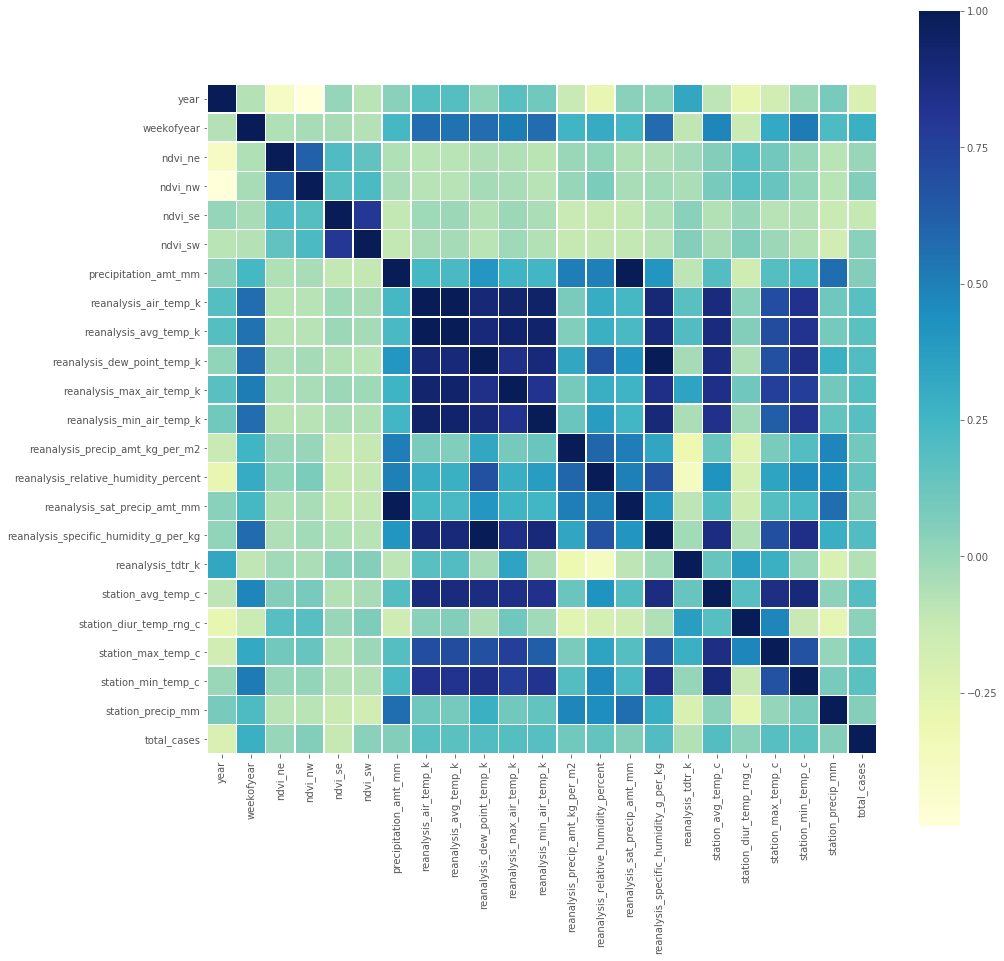

In [16]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(15,15))
g = sns.heatmap(sjcorr, ax=ax,cmap="YlGnBu", square=True, linewidths=.5)
bottom, top = g.get_ylim()

g.set_ylim(bottom+0.5,top-0.5) #this is a fix for the uncentered heatmap

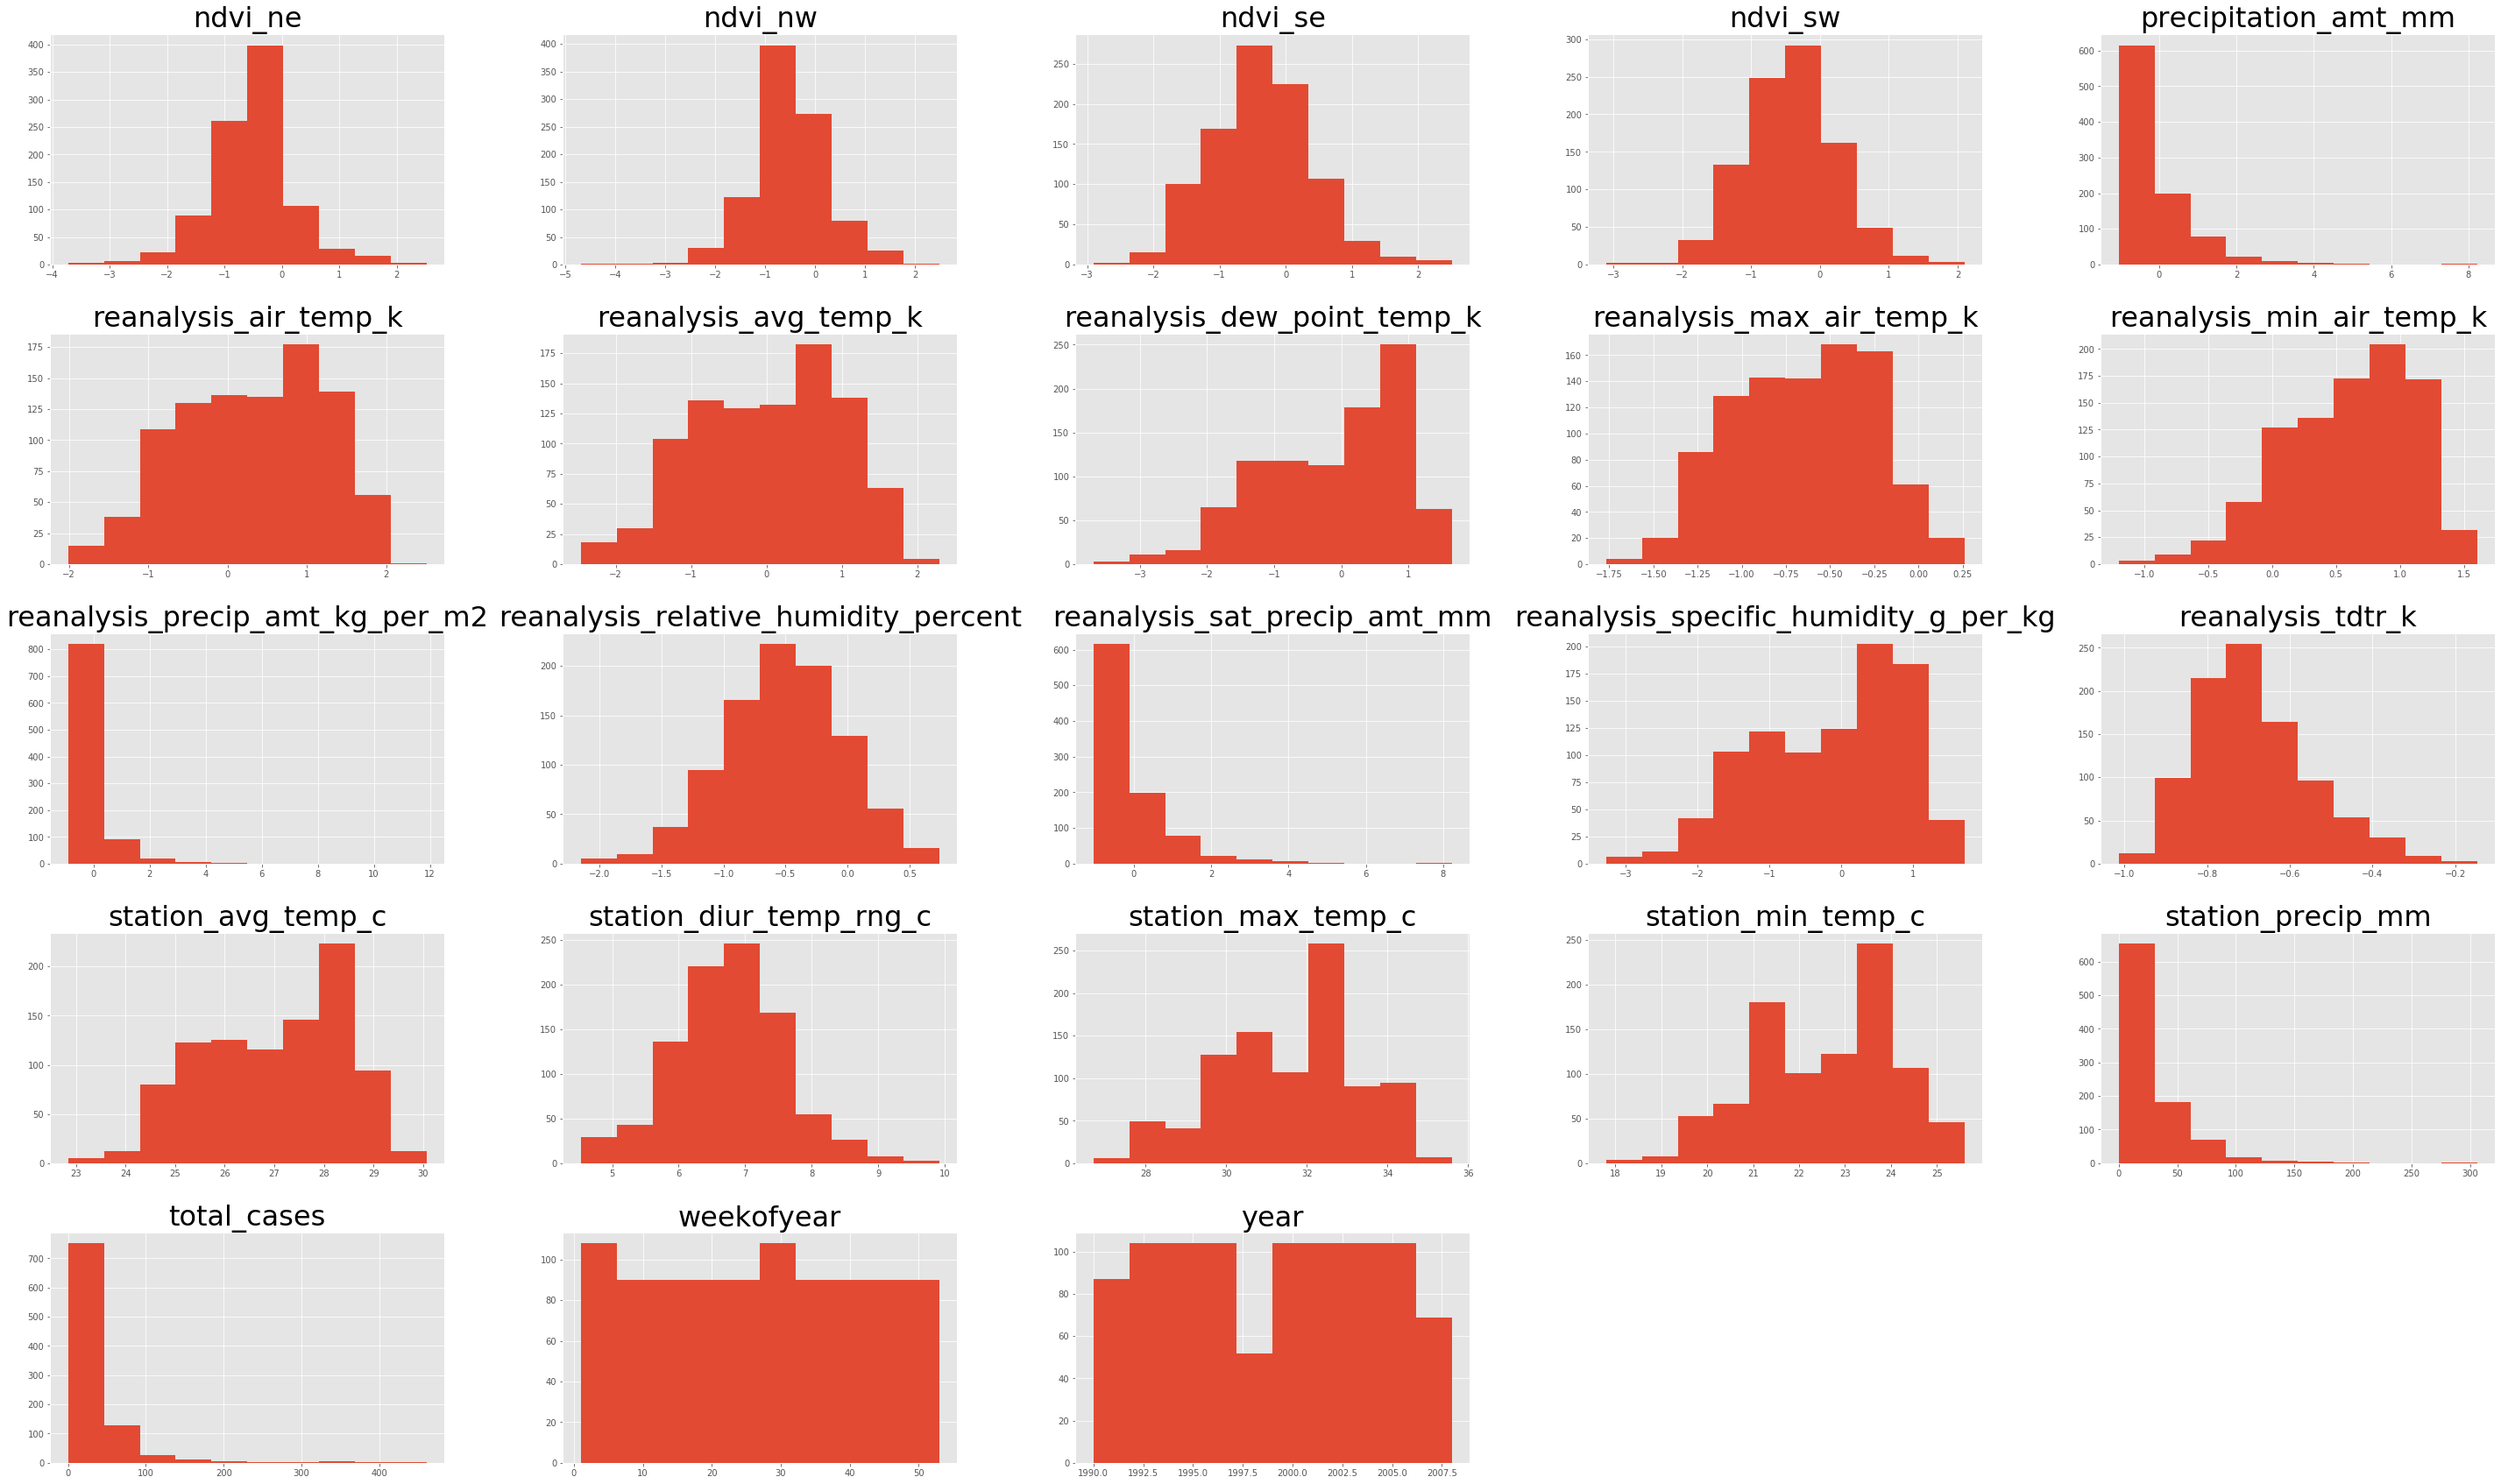

In [17]:
fig = sj_train_data.hist(figsize=(50,30))
[x.title.set_size(32) for x in fig.ravel()]
plt.show()

# Correlations from Iquitos only (train data)

In [18]:
iq_train_data = all_data[(all_data['city']=='iq')& (all_data['set_type'] == 'train')]

iqcorr = iq_train_data.corr()

cmap = sns.diverging_palette(5, 250, as_cmap=True)

iqcorr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
year,1,-0.14,-0.061,0.034,-0.069,-0.013,0.087,0.026,0.008,0.32,-0.16,0.22,0.16,0.25,0.087,0.32,-0.24,0.081,-0.12,0.014,0.13,-0.035,0.18
weekofyear,-0.14,1,0.26,0.23,0.33,0.26,-0.1,0.29,0.3,-0.093,0.4,-0.026,-0.15,-0.28,-0.1,-0.083,0.35,0.084,0.22,0.19,-0.094,-0.045,-0.012
ndvi_ne,-0.061,0.26,1,0.76,0.77,0.84,-0.0086,0.15,0.17,-0.032,0.22,-0.0049,-0.084,-0.14,-0.0086,-0.031,0.17,0.12,0.15,0.14,-0.0078,0.011,0.02
ndvi_nw,0.034,0.23,0.76,1,0.65,0.77,-0.055,0.15,0.17,-0.033,0.2,0.0048,-0.077,-0.13,-0.055,-0.029,0.17,0.12,0.19,0.15,-0.09,-0.016,-0.011
ndvi_se,-0.069,0.33,0.77,0.65,1,0.71,-0.038,0.2,0.21,-0.061,0.26,-0.023,-0.12,-0.19,-0.038,-0.059,0.22,0.13,0.17,0.16,-0.051,0.012,-0.041
ndvi_sw,-0.013,0.26,0.84,0.77,0.71,1,-0.016,0.16,0.18,-0.03,0.23,-0.00024,-0.063,-0.14,-0.016,-0.027,0.17,0.12,0.17,0.17,-0.055,-0.0045,0.031
precipitation_amt_mm,0.087,-0.1,-0.0086,-0.055,-0.038,-0.016,1,-0.048,-0.054,0.47,-0.23,0.33,0.34,0.43,1,0.47,-0.38,0.13,-0.16,-0.0015,0.31,0.37,0.089
reanalysis_air_temp_k,0.026,0.29,0.15,0.15,0.2,0.16,-0.048,1,0.97,0.15,0.75,0.41,-0.087,-0.55,-0.048,0.18,0.55,0.59,0.51,0.65,0.24,-0.14,0.097
reanalysis_avg_temp_k,0.008,0.3,0.17,0.17,0.21,0.18,-0.054,0.97,1,0.14,0.78,0.39,-0.11,-0.54,-0.054,0.17,0.6,0.56,0.5,0.62,0.21,-0.14,0.08
reanalysis_dew_point_temp_k,0.32,-0.093,-0.032,-0.033,-0.061,-0.03,0.47,0.15,0.14,1,-0.26,0.76,0.57,0.74,0.47,1,-0.61,0.34,-0.23,0.095,0.62,0.18,0.23


In [19]:
iqcorr[['total_cases']]

,total_cases
year,0.179451
weekofyear,-0.011850
ndvi_ne,0.019740
ndvi_nw,-0.010520
ndvi_se,-0.041153
ndvi_sw,0.031369
precipitation_amt_mm,0.089410
reanalysis_air_temp_k,0.096666
reanalysis_avg_temp_k,0.080056
reanalysis_dew_point_temp_k,0.228864


(23.0, 0.0)

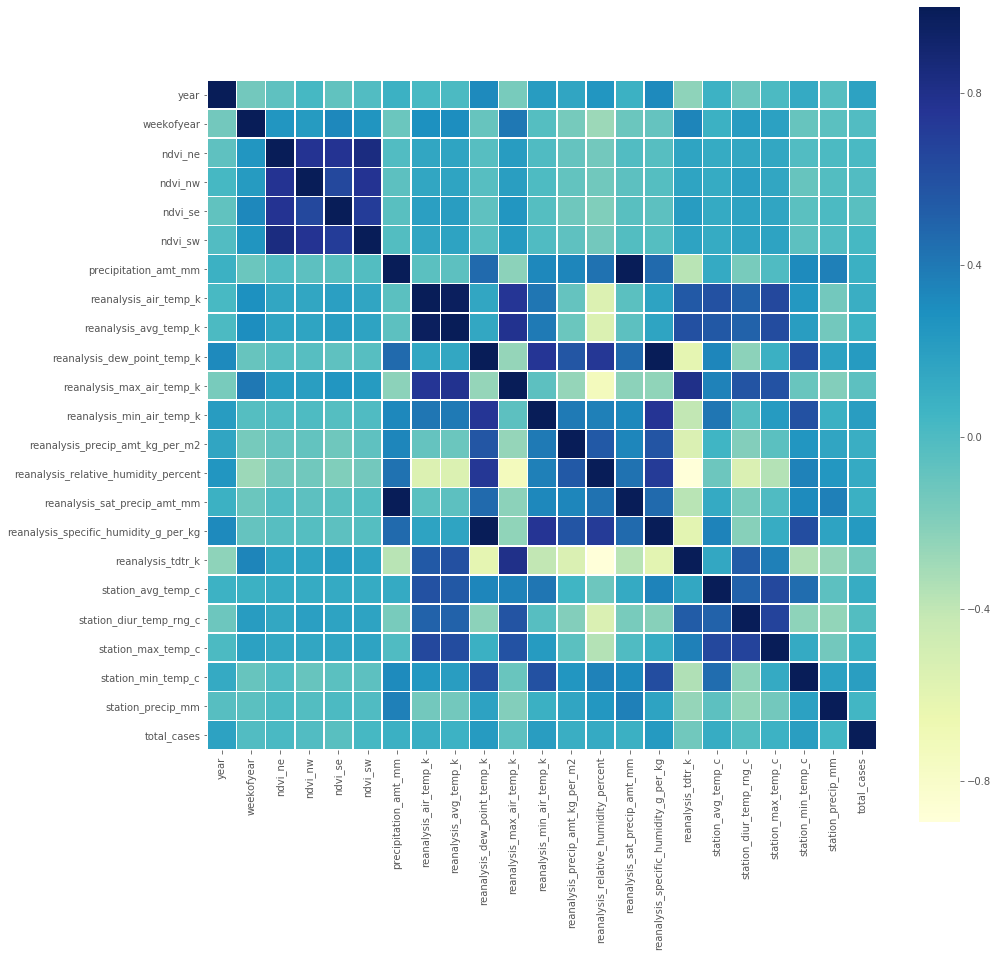

In [20]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(15,15))
g = sns.heatmap(iqcorr, ax=ax,cmap="YlGnBu", square=True, linewidths=.5)
bottom, top = g.get_ylim()

g.set_ylim(bottom+0.5,top-0.5) #this is a fix for the uncentered heatmap

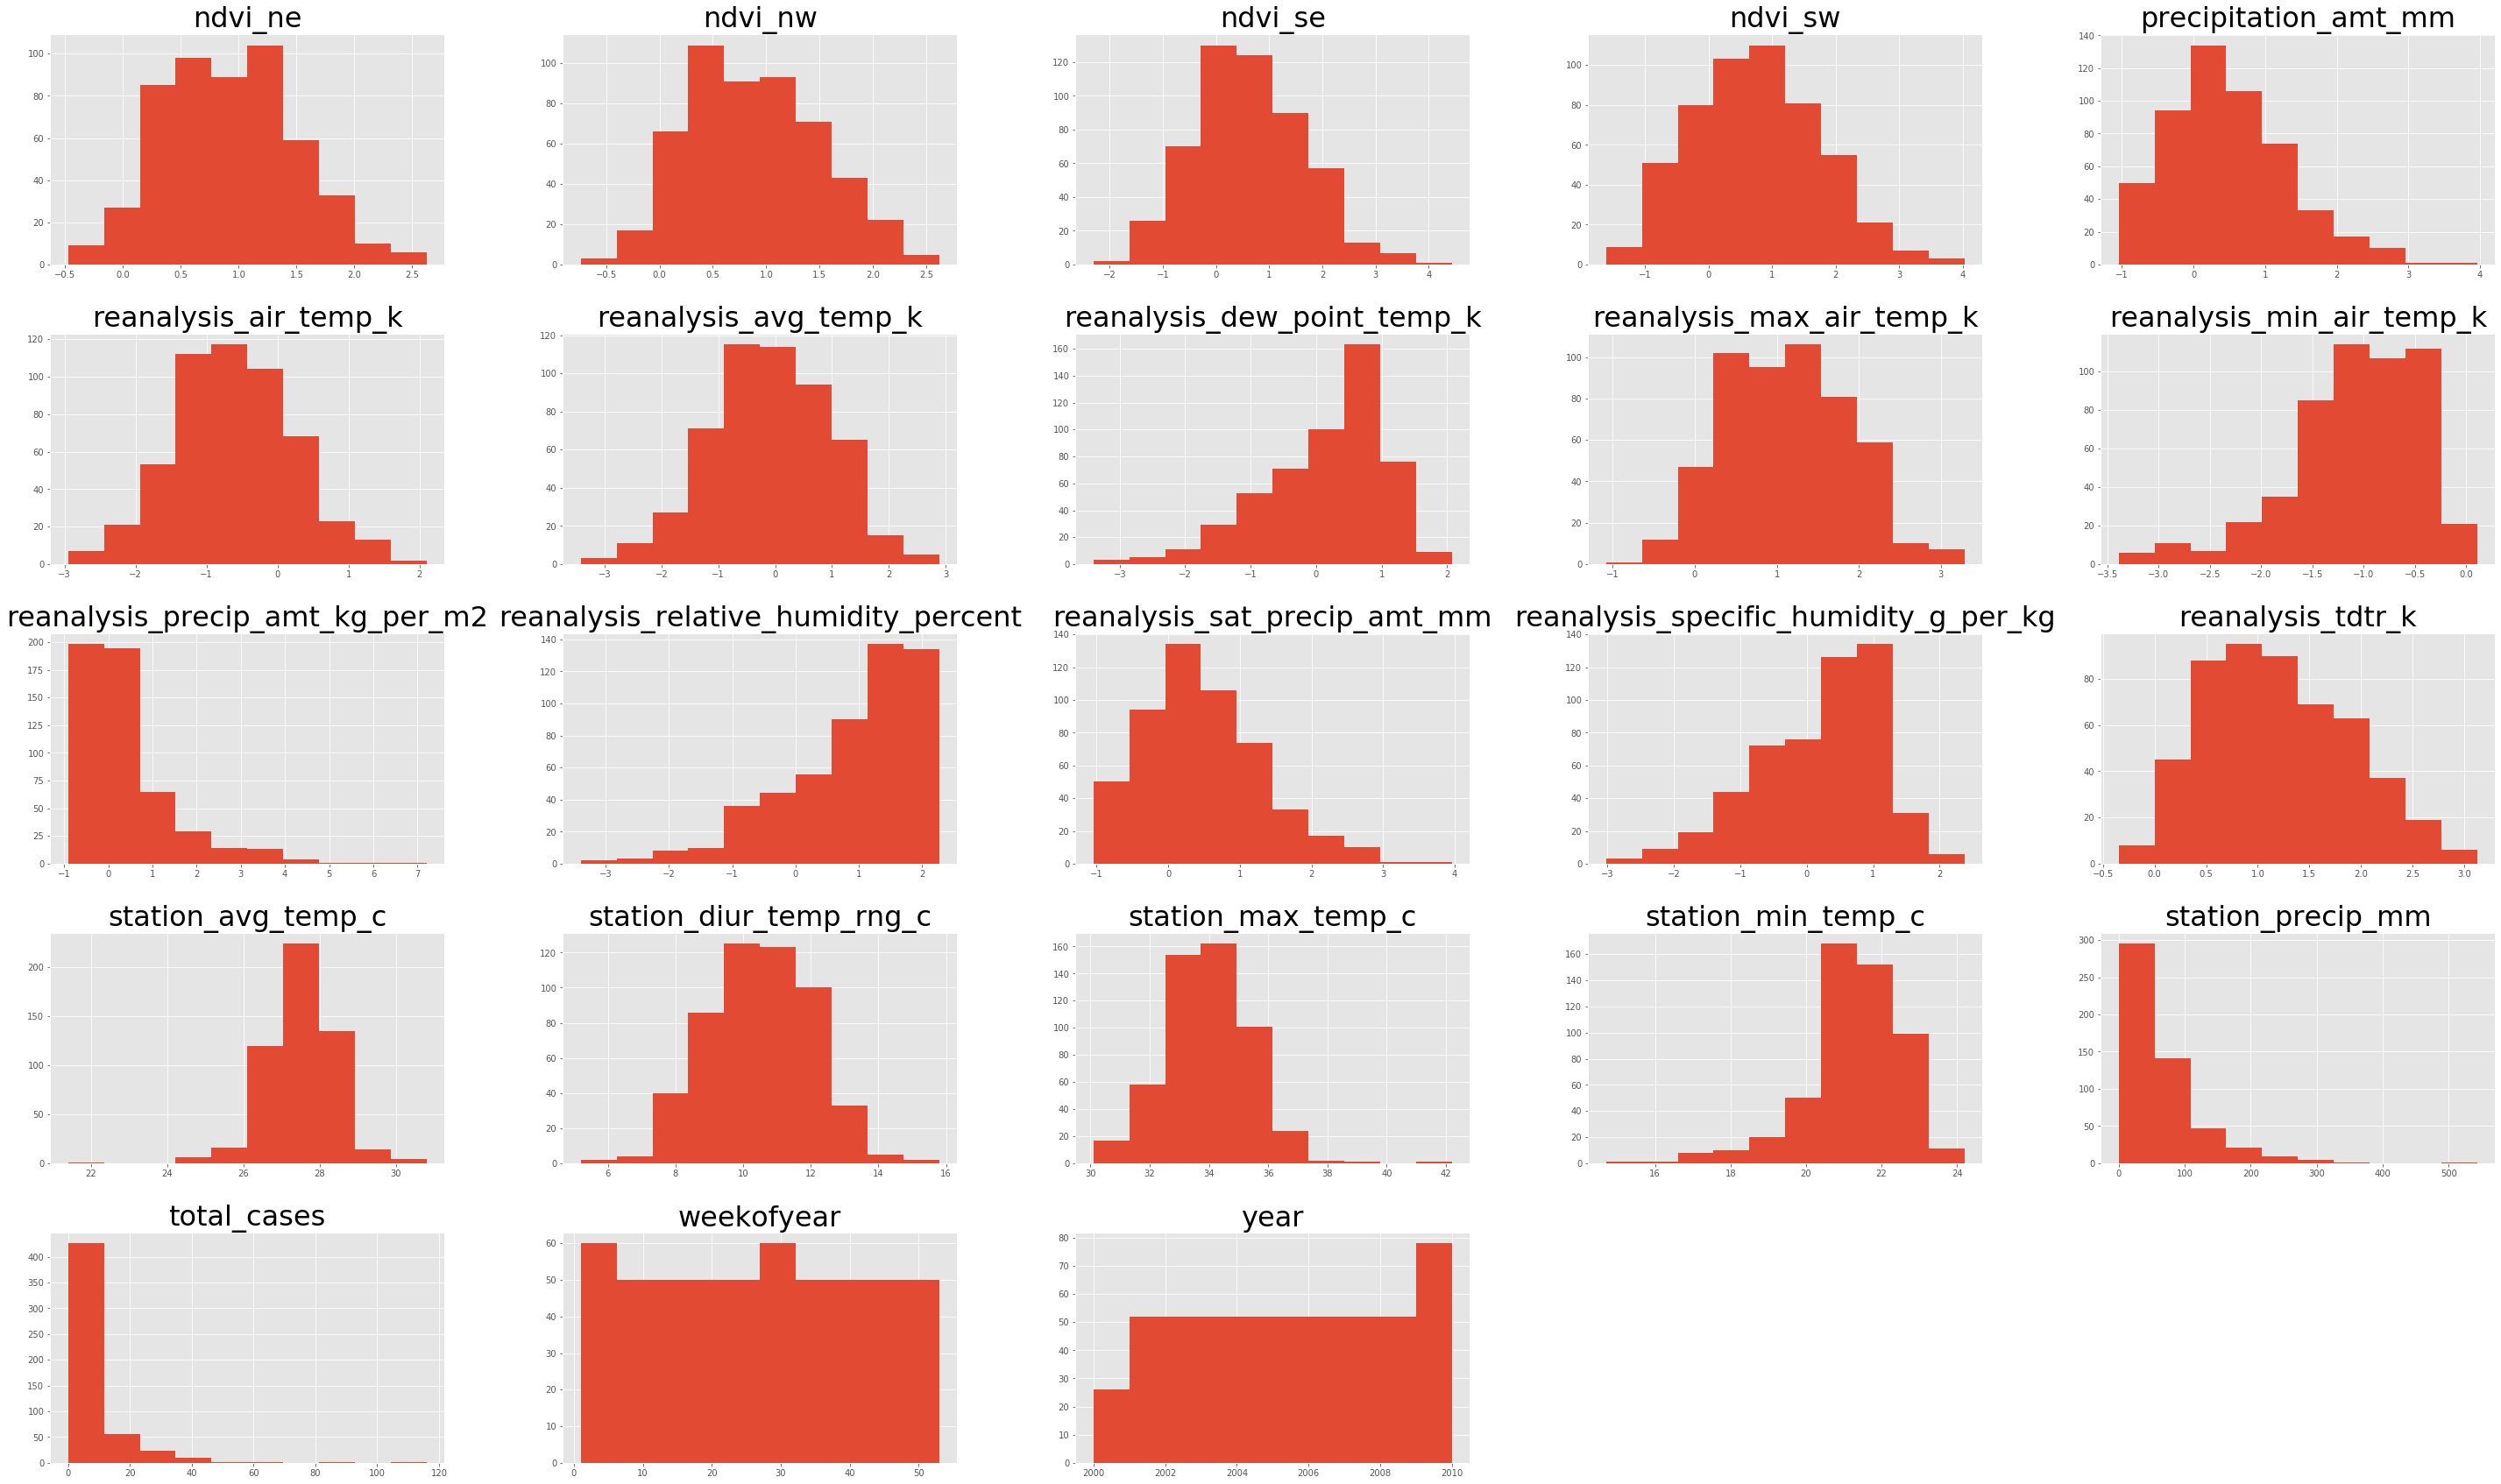

In [21]:
fig = iq_train_data.hist(figsize=(50,30))
[x.title.set_size(32) for x in fig.ravel()]
plt.show()

## Seeing here `total_cases`, there doesn't seem to be any strong corelations in the data.

## Both Iquitos and San Juan have highest corelation in `reanalysis_specific_humidity_g_per_kg`

#### This makes sense since mosquitos tend to reproduce on water/stuck water

# Regression Plot for both cities over all data

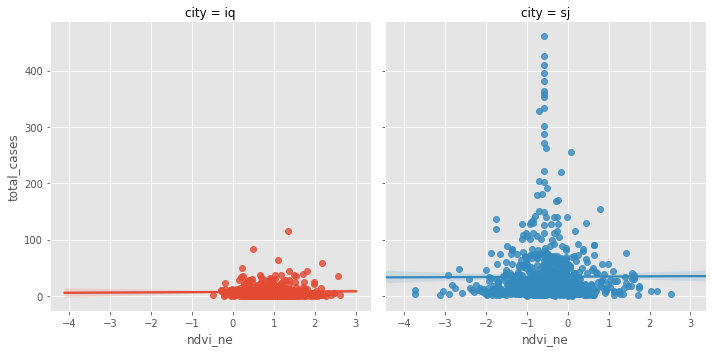

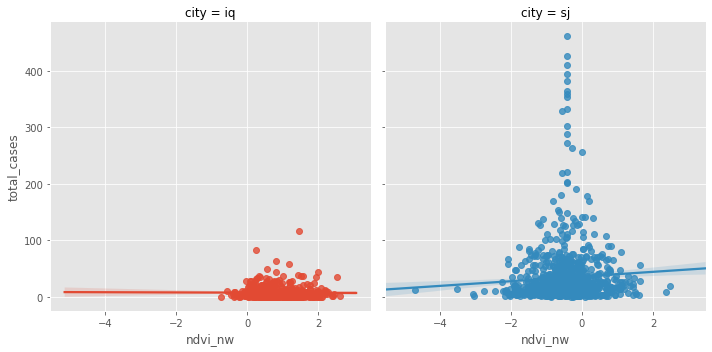

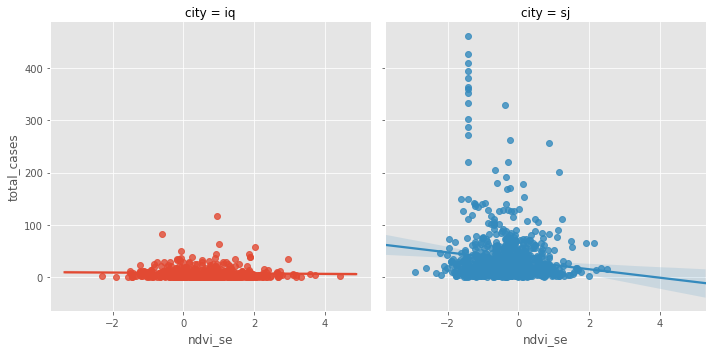

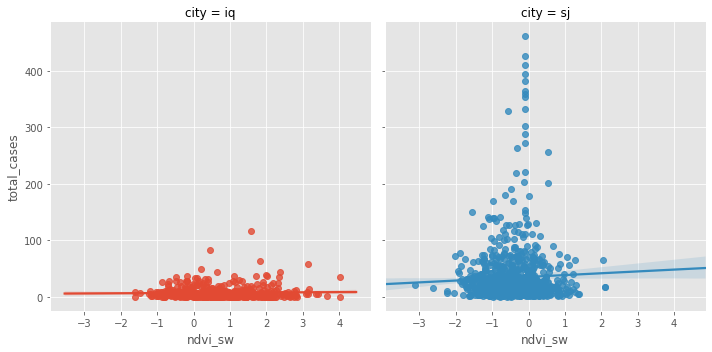

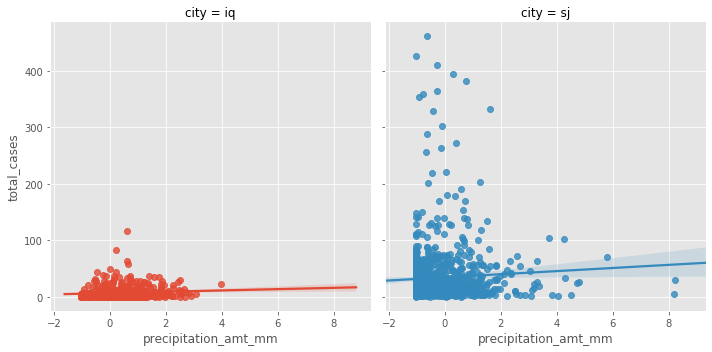

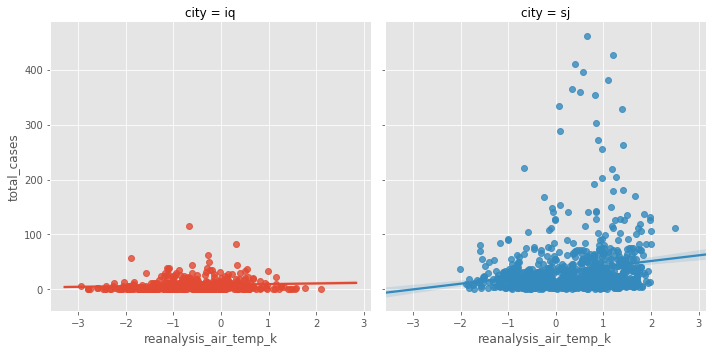

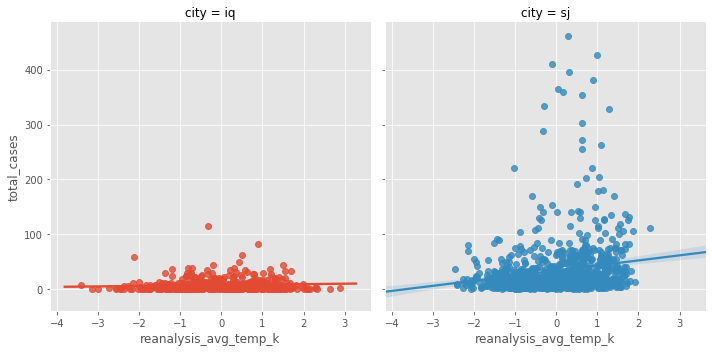

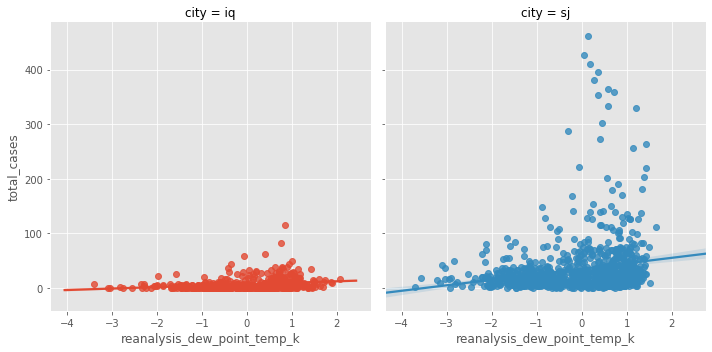

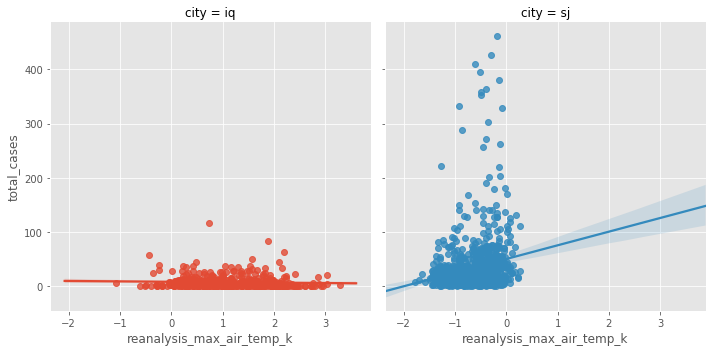

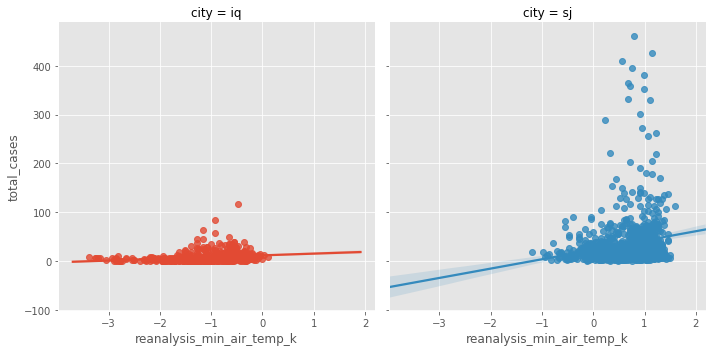

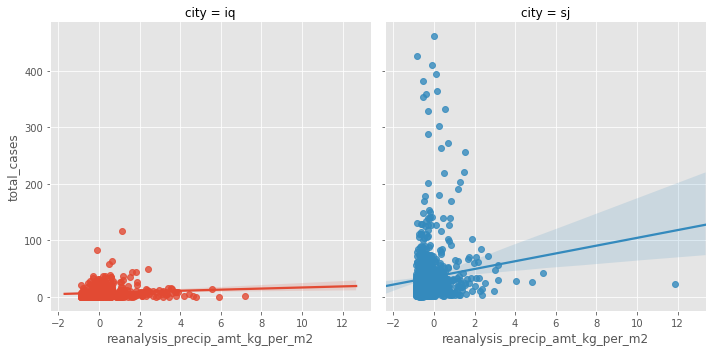

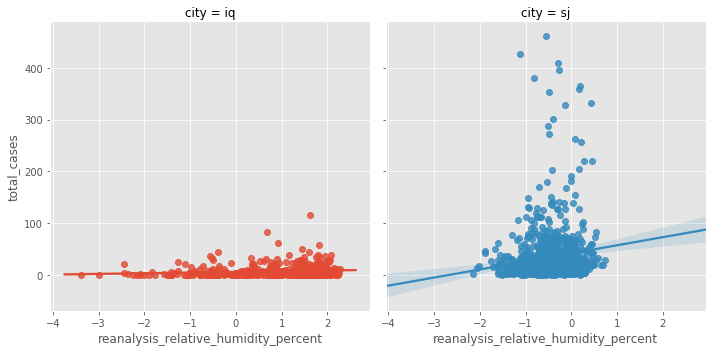

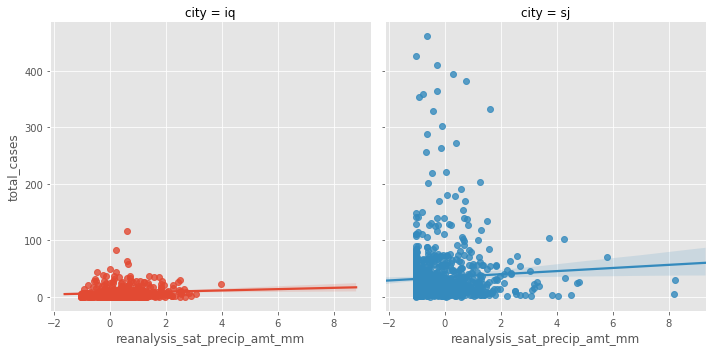

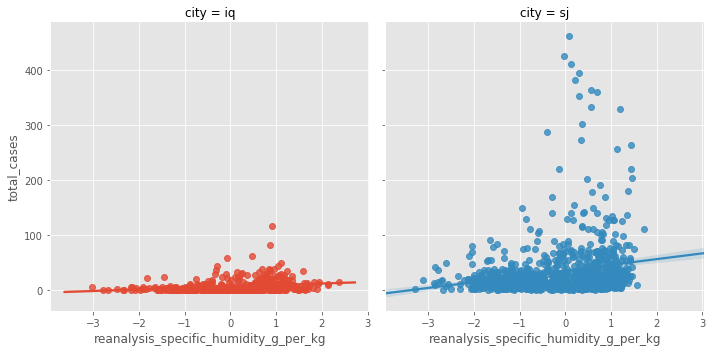

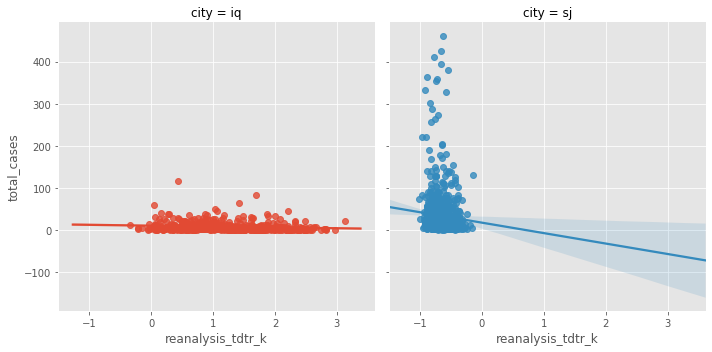

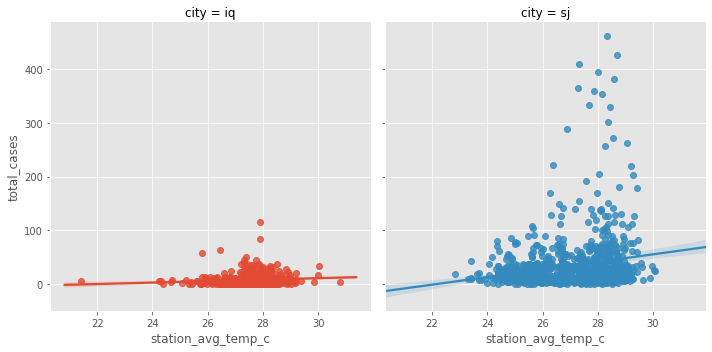

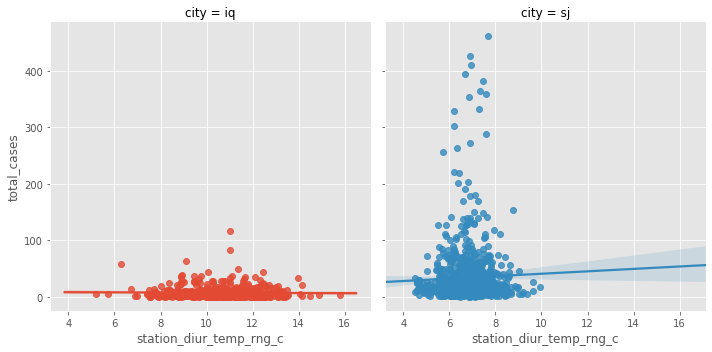

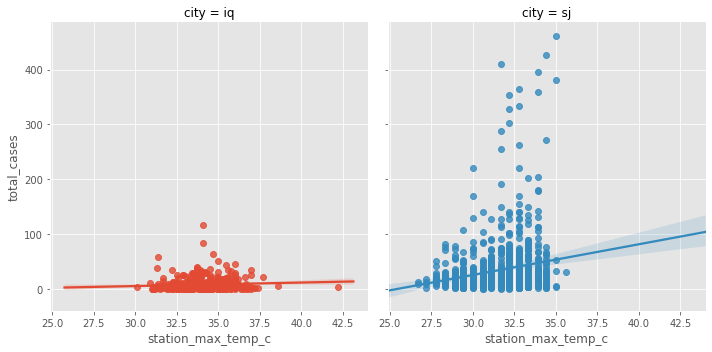

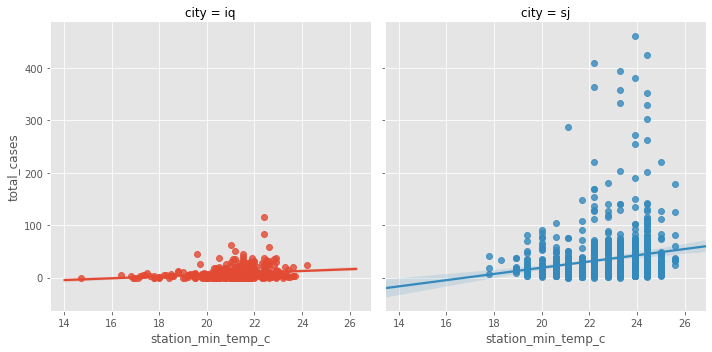

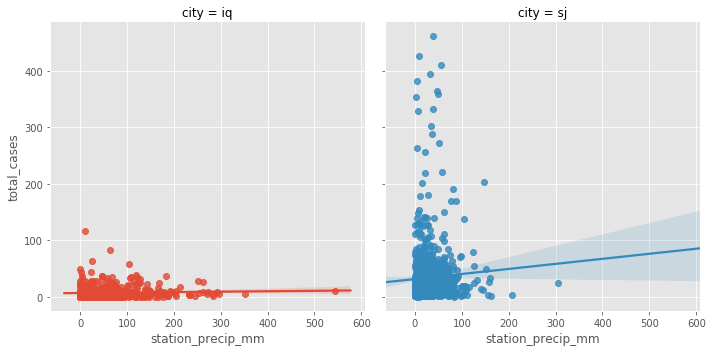

In [22]:
all_train_data = all_data[all_data['set_type'] == 'train']

#Grabbing only the numerical columns to iterate
colums_to_iter = all_train_data.columns[4:-2].values

#graphing a regression for all the data in both cities
for col in colums_to_iter:
    sns.lmplot(col,'total_cases',hue='city',col='city',
               data = all_train_data)    
    plt.show()

## Here one can see that San Juan has a higher corelation with the dataset (partly because it has more data to use).

In [23]:
#using datetime as index
date_all_train_data = all_train_data.set_index(all_train_data.week_start_date)

# Total Cases vs Time plot

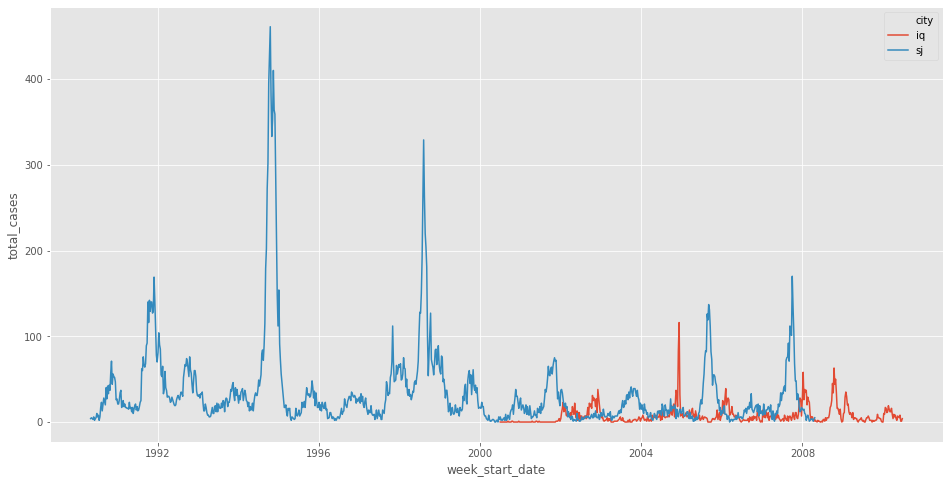

In [24]:
fig, ax = plt.subplots(figsize=(16,8))

sns.lineplot('week_start_date','total_cases',hue='city',data=all_train_data, ax=ax)

plt.show()

## It is visible how total cases spikes have decreased as time went going (which could be due to medical advancements). It is also visible that San Juan and Iquitos both have different spiking seasons. This must be true as not only are they at different locations this infection gets spread by people as well, not just mosquitos as a variable.

# Total Cases vs Year

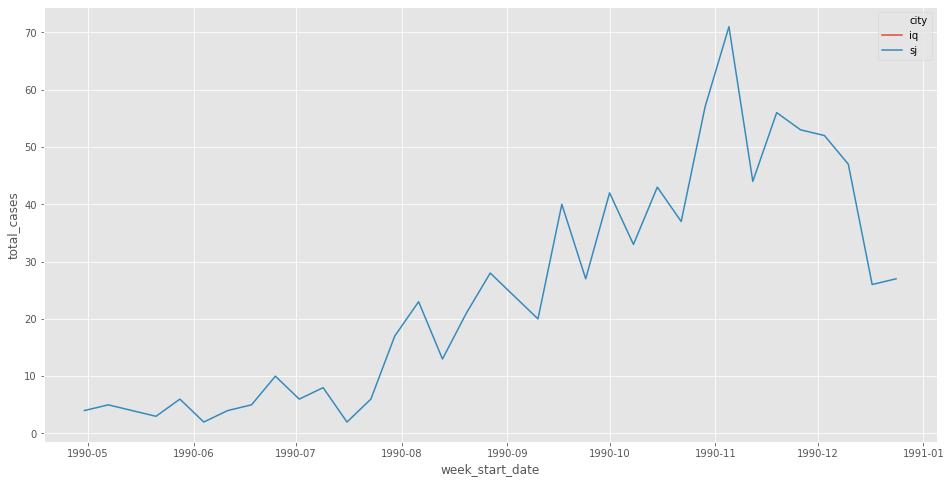

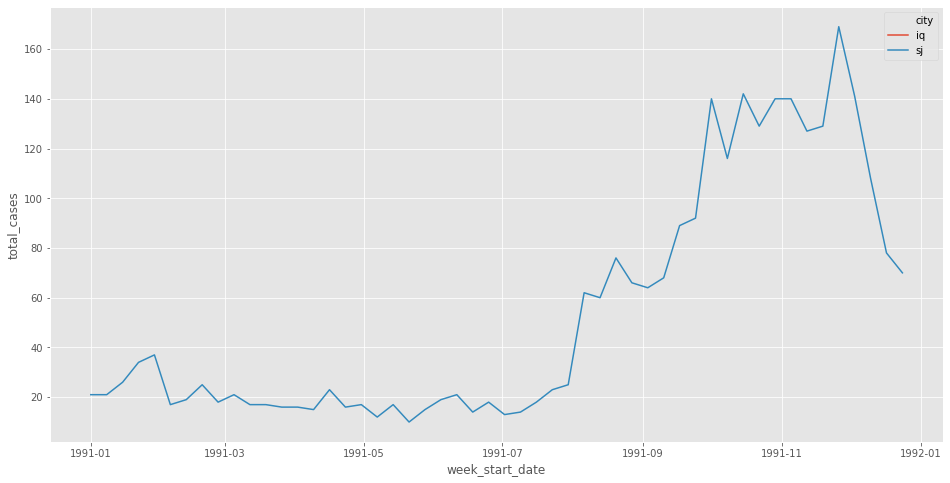

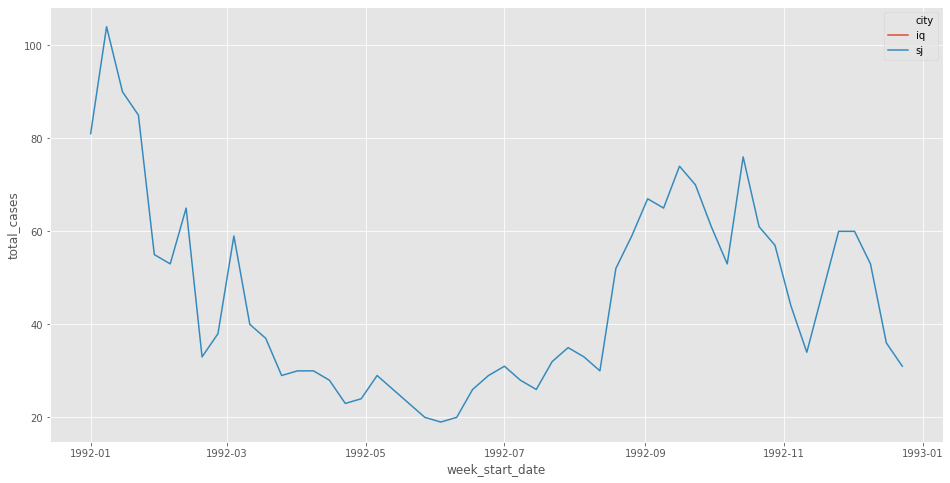

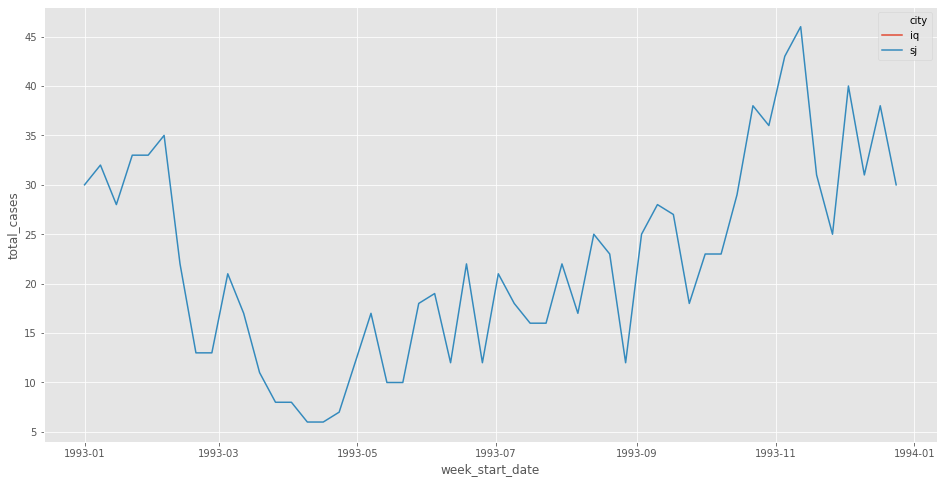

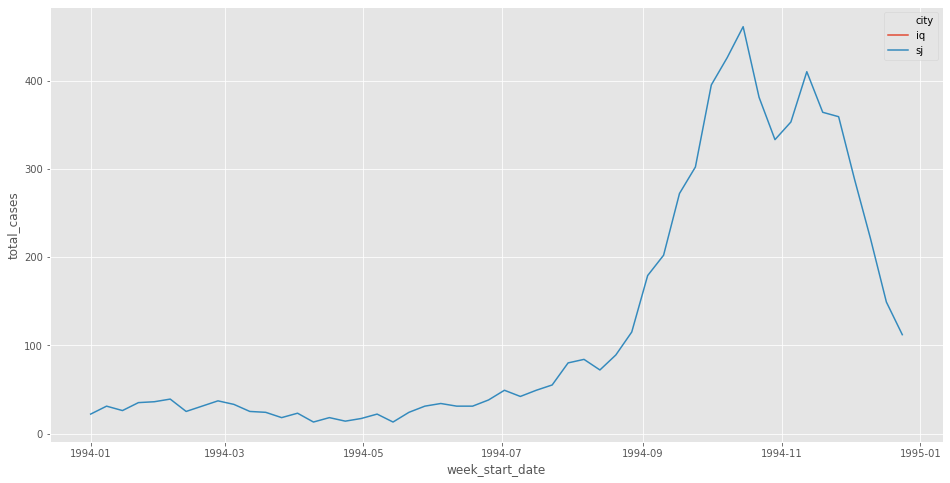

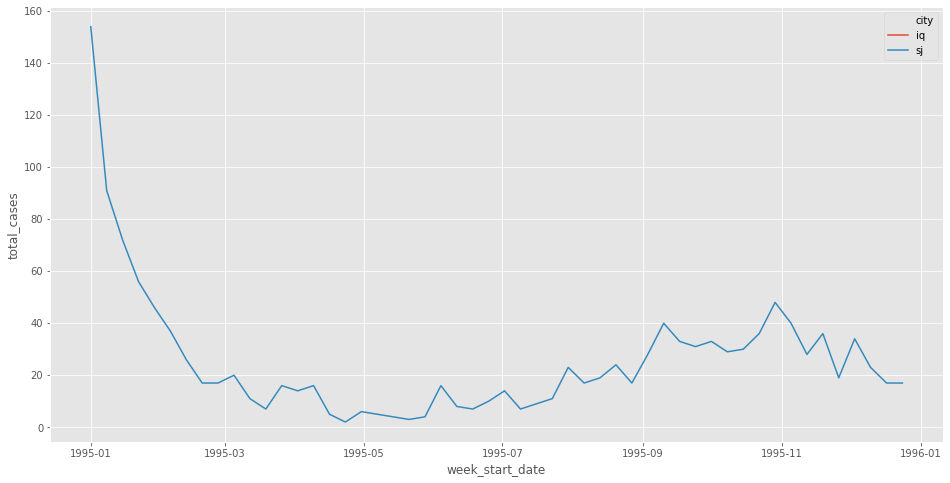

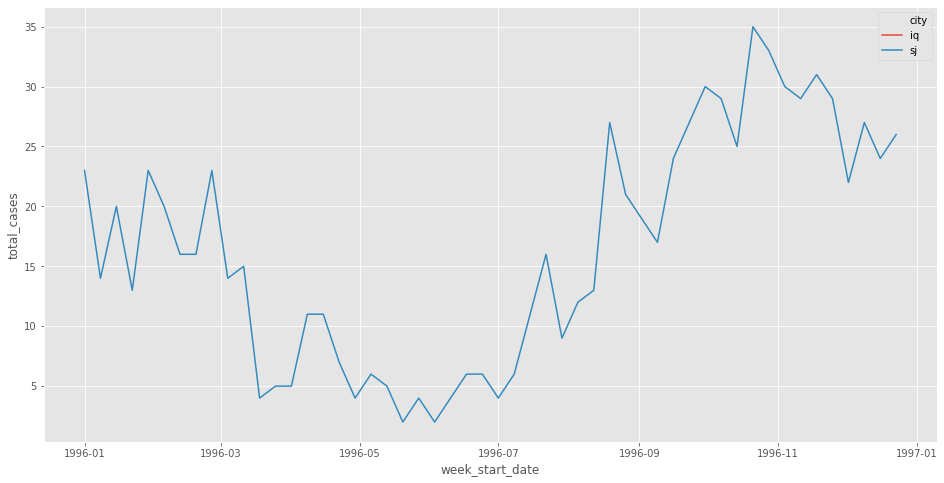

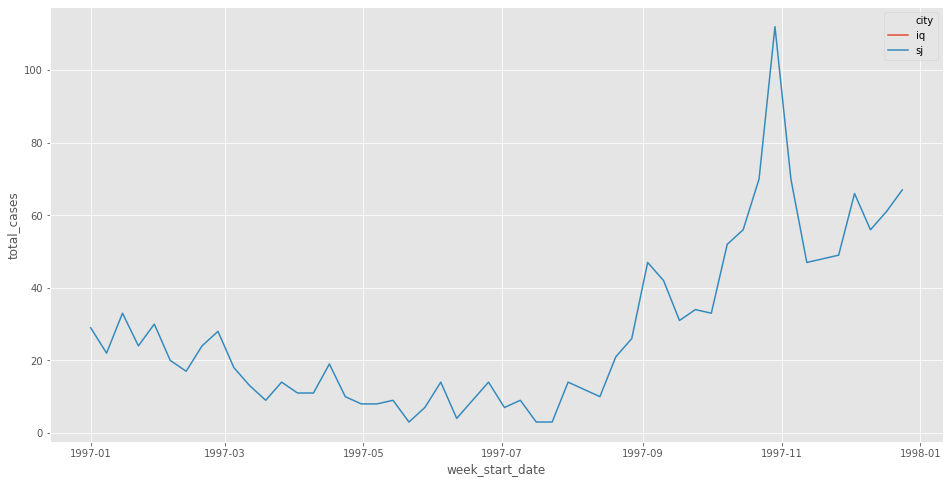

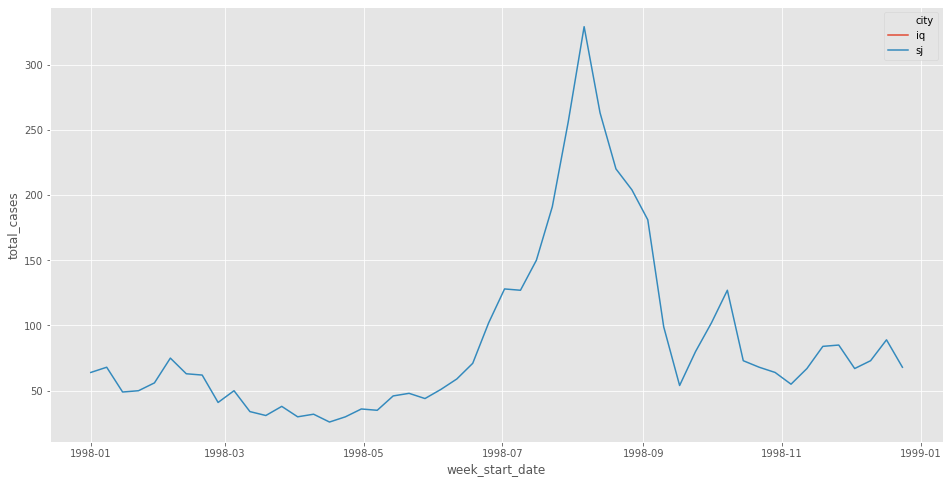

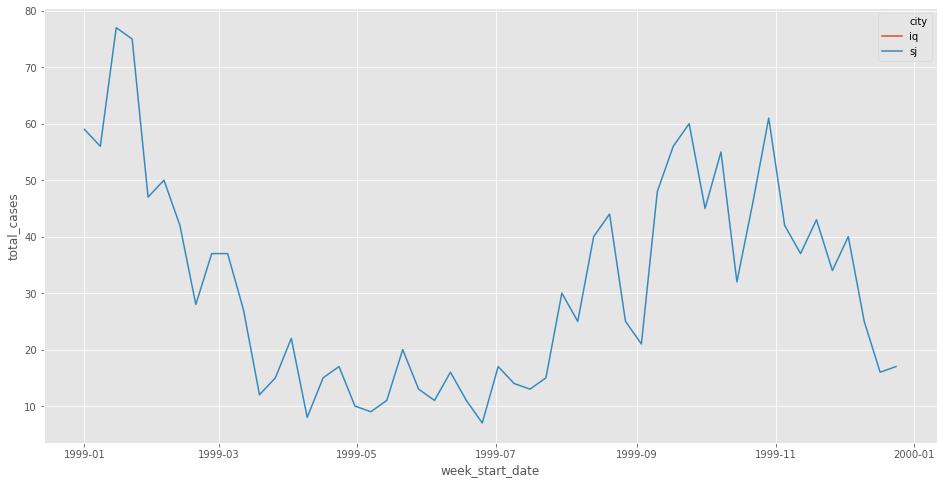

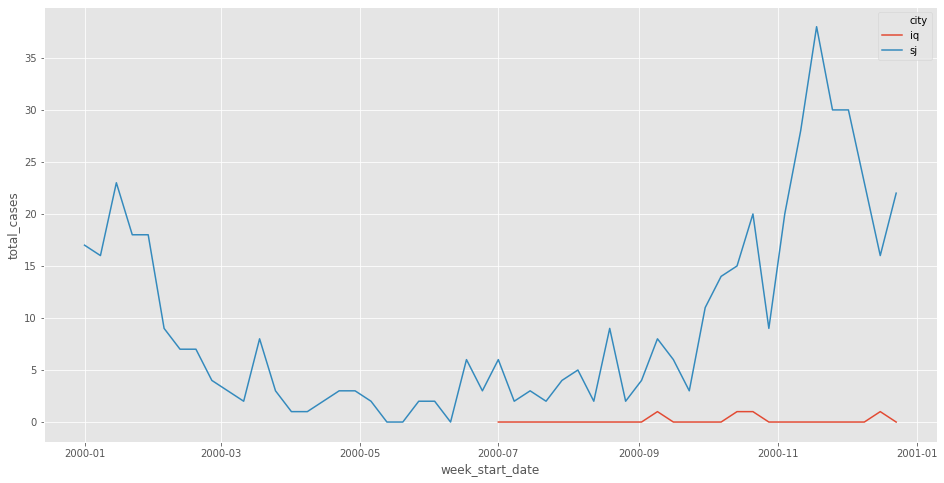

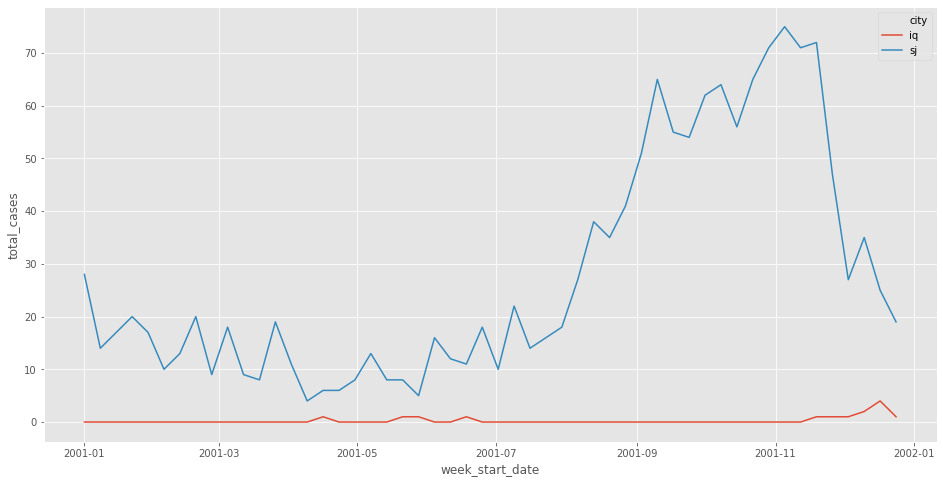

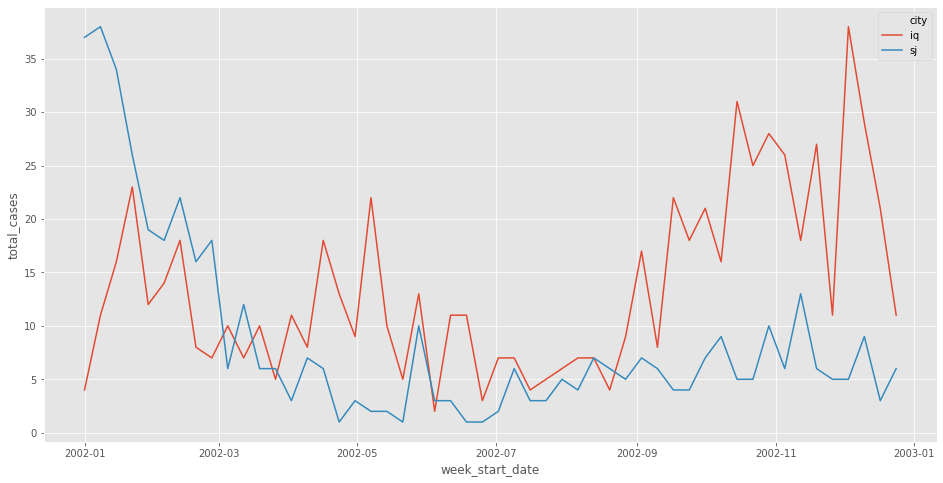

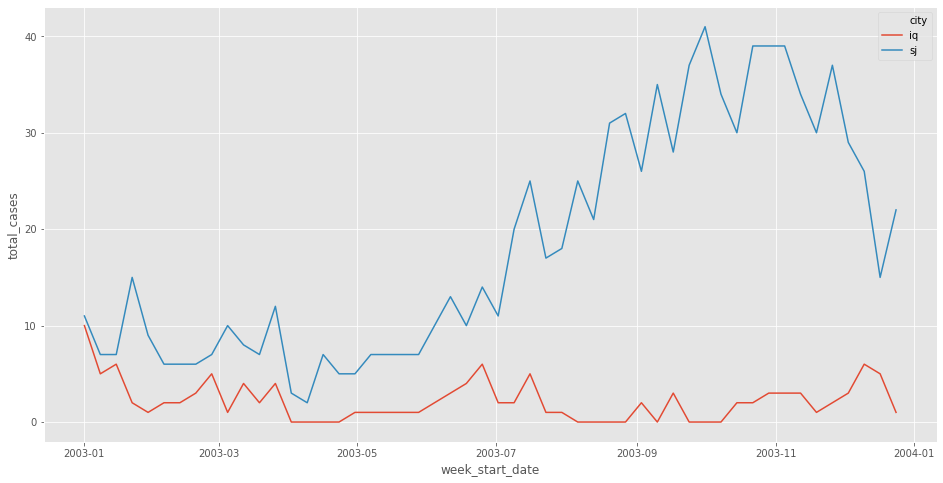

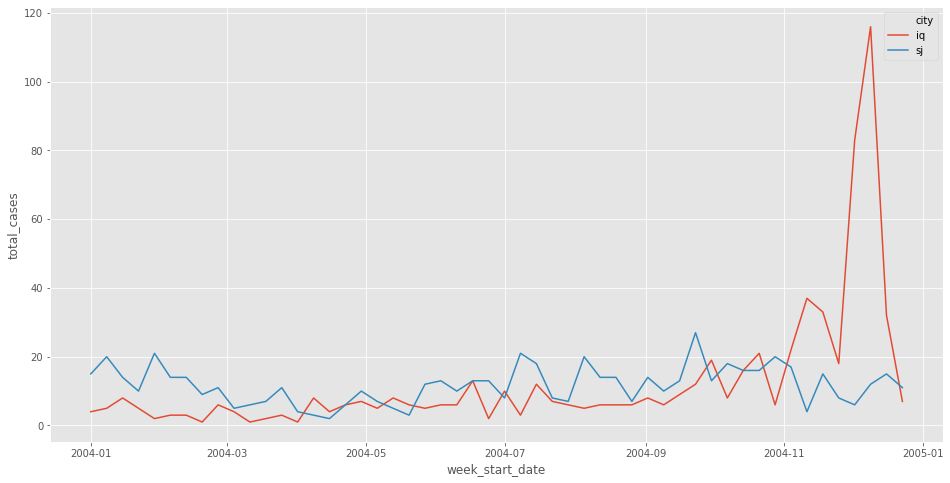

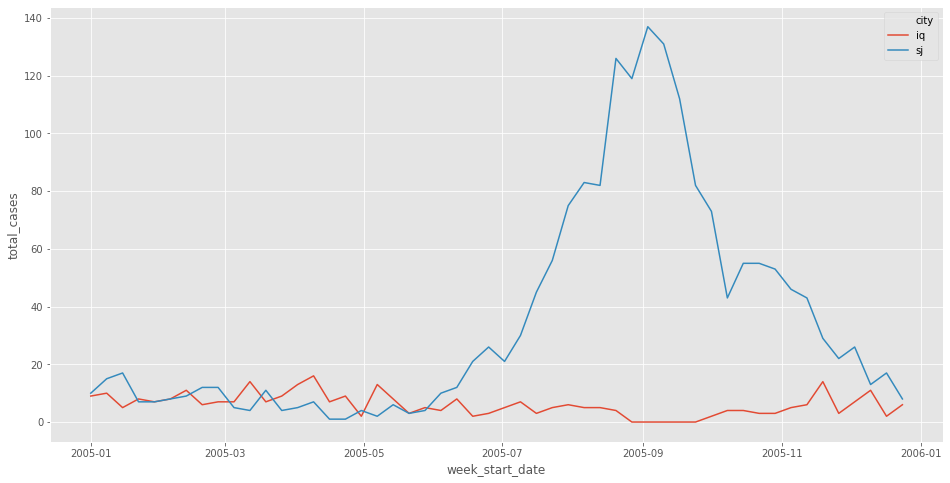

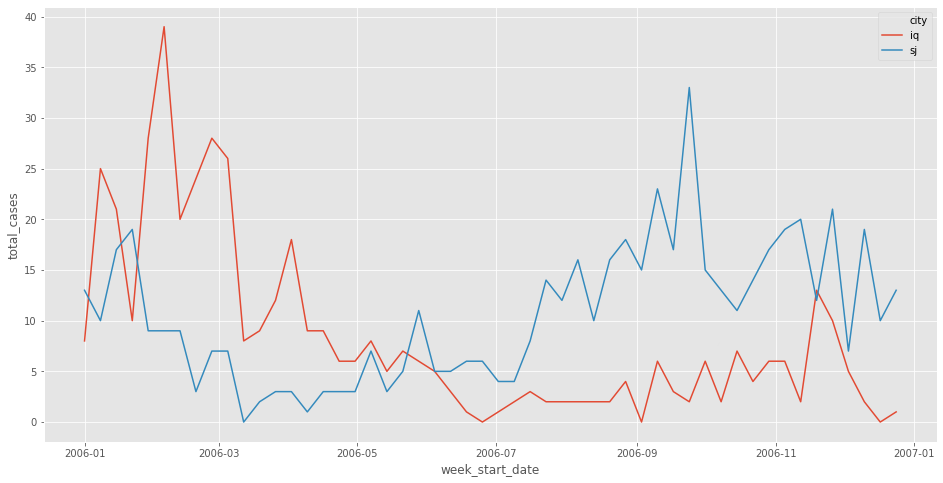

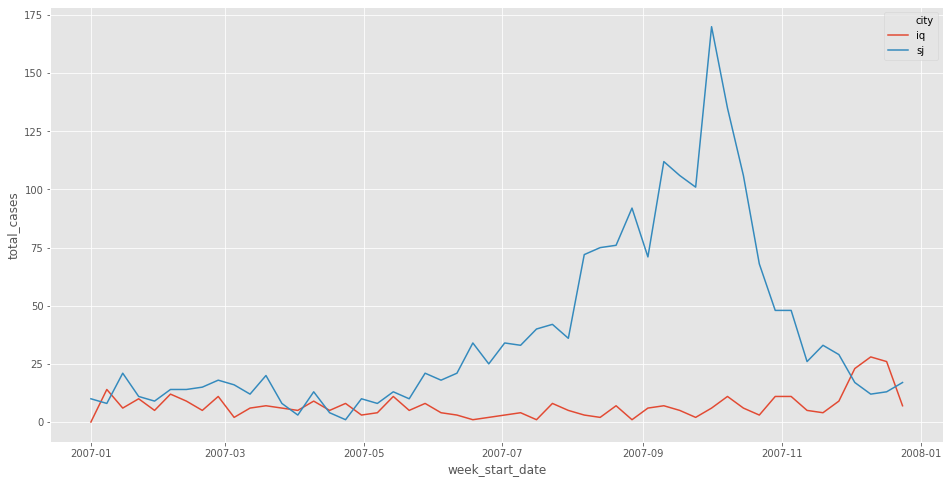

In [25]:
for i in range(1990,2008):
    fig, ax = plt.subplots(figsize=(16,8))
    sns.lineplot('week_start_date','total_cases',hue='city',
                 data=date_all_train_data.loc[str(i)], ax=ax)
    plt.plot()

In [26]:
mean_sj_cases_week = sj_train_data.groupby('weekofyear').mean()

# Mean Dengue Cases per week in San Juan 

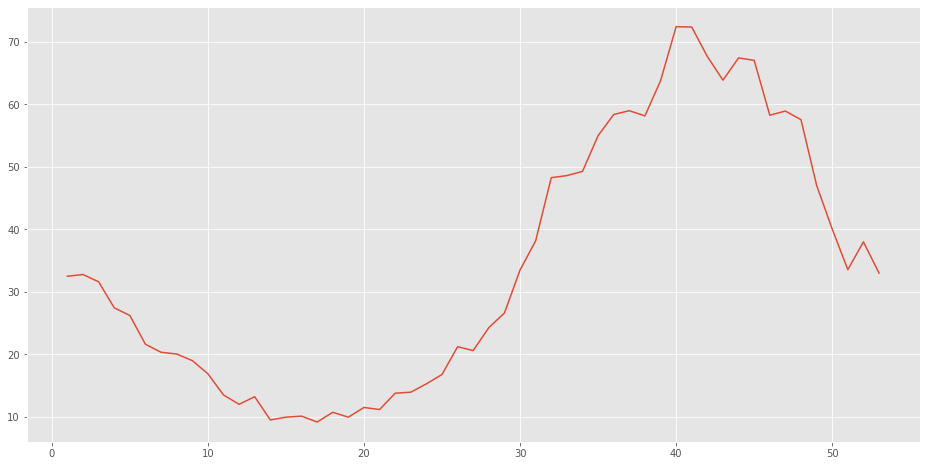

In [27]:
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(mean_sj_cases_week.index.values, mean_sj_cases_week.total_cases.values, ax=ax)

In [28]:
mean_iq_cases_week = iq_train_data.groupby('weekofyear').mean()

# Mean Dengue Cases per week in Iquitos

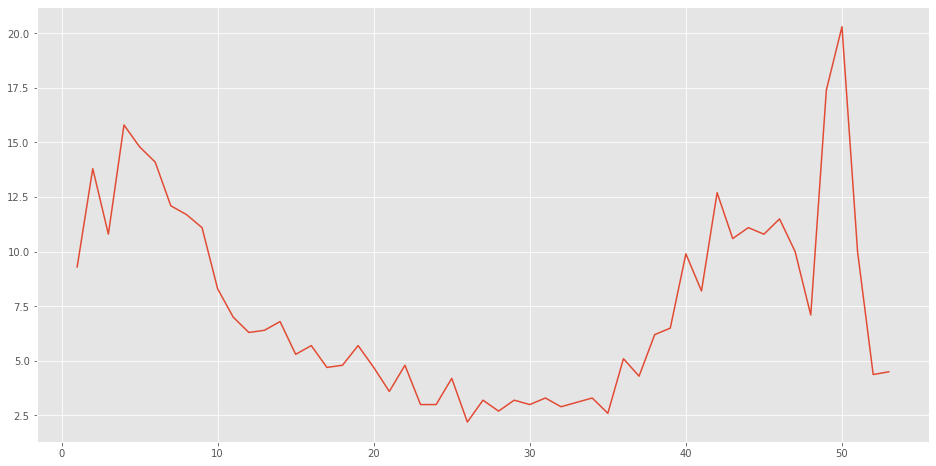

In [29]:
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(mean_iq_cases_week.index.values, mean_iq_cases_week.total_cases.values, ax=ax)

## Here it is easier to see that the highest peak of dengue infections in San Juan tend to be at november-december. Approaching the summer tends to be where the least cases are diagnosed.

## For Iquitos there isnt as much data for me to give an accurate estimate on which seasons get the most dengue cases. But according to the mean lineplot, the peak tends to be about December-February

# Creating a Linear Regression Machine learning algorithm

In [30]:
numeric_cols = ['ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw','precipitation_amt_mm', 
                          'reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
                         'reanalysis_dew_point_temp_k','reanalysis_max_air_temp_k',
                         'reanalysis_min_air_temp_k','reanalysis_precip_amt_kg_per_m2',
                         'reanalysis_sat_precip_amt_mm',
                         'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
                         'station_avg_temp_c','station_diur_temp_rng_c', 'station_max_temp_c',
                         'station_min_temp_c','station_precip_mm']

X_sj = sj_train_data[numeric_cols].values
y_sj=sj_train_data[['total_cases']].values

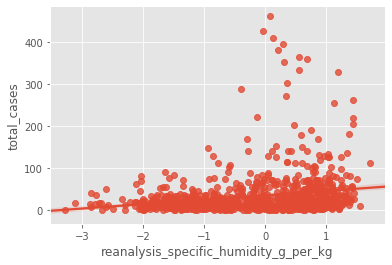

In [31]:
sns.regplot(y='total_cases',x='reanalysis_specific_humidity_g_per_kg',data=sj_train_data)

## Verifying which random state performs best

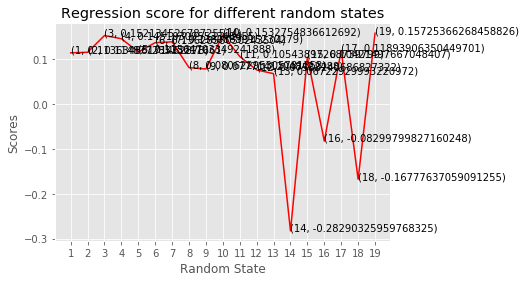

In [32]:
scores = []
for i in range(1,20):
    X_train_sj, X_test_sj, y_train_sj, y_test_sj = train_test_split(X_sj,y_sj,test_size=0.3, 
                                                                    random_state=i)
    regressor = LinearRegression(n_jobs=12)
    regressor.fit(X_train_sj,y_train_sj)
    y_sj_pred= regressor.predict(X_test_sj)
    scores.append(regressor.score(X_test_sj,y_test_sj))

plt.plot([k for k in range(1,20)], scores, color = 'red')
for i in range(1,20):
    plt.text(i, scores[i-1], (i, scores[i-1]))
plt.xticks([i for i in range(1,20)])
plt.xlabel('Random State')
plt.ylabel('Scores')
plt.title('Regression score for different random states')
plt.show()    

In [33]:
X_train_sj, X_test_sj, y_train_sj, y_test_sj = train_test_split(X_sj,y_sj,test_size=0.3, 
                                                                random_state=10)
regressor = LinearRegression(n_jobs=12)
regressor.fit(X_train_sj,y_train_sj)
y_sj_pred= regressor.predict(X_test_sj)
print(regressor.score(X_test_sj,y_test_sj))

0.1532754836612692


In [34]:
X_iq = iq_train_data[numeric_cols].values
y_iq = iq_train_data[['total_cases']].values

X_train_iq, X_test_iq, y_train_iq, y_test_iq = train_test_split(X_iq,y_iq,test_size=0.3, 
                                                                    random_state=10)
regressor2 = LinearRegression(n_jobs=12)
regressor2.fit(X_train_iq,y_train_iq)
y_iq_pred= regressor2.predict(X_test_iq)
print(regressor2.score(X_test_iq,y_test_iq))

-0.021842261738501456


## It is easy to conclude that using Linear Regression model won't work. As seen previously in the plots, the data is not linearly corelated, specially with the Iquitos data. Hence, I must look for a deeper method of solving this issue. I wont bother using KNN nor Logistic Regression as they are used more as classifier and it does not fit this type of data.

# Attempting a Poisson Regression Model (on SJ)

In [35]:
sj_train_data_dates = date_all_train_data[date_all_train_data['city'] == 'sj']

sj_train_data_dates

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,set_type
week_start_date,,,,,,,,,,,,,,,,,,,,,
1990-04-30,sj,1990,18,1990-04-30,-0.052787,-0.193201,-0.069609,-0.284390,-0.751345,-0.830624,...,-0.751345,-1.792727,-0.655061,25.442857,6.900000,29.4,20.0,16.0,4.0,train
1990-05-07,sj,1990,19,1990-05-07,0.275463,0.115456,-0.548334,-0.543272,-0.504407,-0.370095,...,-0.504407,-0.913462,-0.727664,26.714286,6.371429,31.7,22.2,8.6,5.0,train
1990-05-14,sj,1990,20,1990-05-14,-0.679794,0.362636,-0.616673,-0.363628,-0.226128,0.040980,...,-0.226128,0.040614,-0.747831,26.714286,6.485714,32.2,22.8,41.4,4.0,train
1990-05-21,sj,1990,21,1990-05-21,-0.010918,0.941419,0.315661,0.397224,-0.681538,0.189338,...,-0.681538,-0.072989,-0.711530,27.471429,6.771429,33.3,23.3,4.0,3.0,train
1990-05-28,sj,1990,22,1990-05-28,0.457978,1.078957,0.628964,0.531213,-0.867691,0.572597,...,-0.867691,0.274284,-0.546158,28.942857,9.371429,35.0,23.9,5.8,6.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-03-25,sj,2008,13,2008-03-25,-0.363341,-1.346151,1.414396,1.103265,-0.400646,-1.273637,...,-0.400646,-2.031015,-0.582459,25.042857,5.785714,30.0,21.1,1.8,4.0,train
2008-04-01,sj,2008,14,2008-04-01,-1.167311,-1.160984,-1.117957,-1.585539,-0.955543,-0.463849,...,-0.955543,-1.372490,-0.630861,26.242857,6.814286,30.6,22.2,0.5,3.0,train
2008-04-08,sj,2008,15,2008-04-08,-1.980650,-1.449305,-0.874320,-0.710215,-0.643547,-0.912015,...,-0.643547,-1.681895,-0.780099,25.000000,5.714286,29.4,21.7,30.7,1.0,train


In [36]:
#Training dataset for poisson

mask_sj = np.random.rand(len(sj_train_data_dates)) < 0.8

sj_train_poisson = sj_train_data_dates[mask_sj].copy()

sj_test_poisson = sj_train_data_dates[~mask_sj].copy()

In [37]:
len(sj_train_poisson)

746

In [38]:
len(sj_test_poisson)

190

In [39]:
#Regression expression for patsy

regression_var_cols = ['weekofyear','ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw','precipitation_amt_mm', 
                          'reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
                         'reanalysis_dew_point_temp_k','reanalysis_max_air_temp_k',
                         'reanalysis_min_air_temp_k','reanalysis_precip_amt_kg_per_m2',
                         'reanalysis_sat_precip_amt_mm',
                         'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
                         'station_avg_temp_c','station_diur_temp_rng_c', 'station_max_temp_c',
                         'station_min_temp_c','station_precip_mm']

expr = """total_cases ~ weekofyear + ndvi_ne + ndvi_nw + 
            ndvi_se + ndvi_sw + precipitation_amt_mm + reanalysis_air_temp_k + 
            reanalysis_avg_temp_k + reanalysis_dew_point_temp_k + reanalysis_max_air_temp_k +
            reanalysis_min_air_temp_k + reanalysis_precip_amt_kg_per_m2 + 
            reanalysis_sat_precip_amt_mm + reanalysis_specific_humidity_g_per_kg +
            reanalysis_tdtr_k + station_avg_temp_c + station_diur_temp_rng_c + station_max_temp_c 
            + station_min_temp_c + station_precip_mm"""

In [40]:
y_sj_train_poisson, X_sj_train_poisson = dmatrices(expr, 
                                                   sj_train_poisson, return_type='dataframe')

y_sj_test_poisson, X_sj_test_poisson = dmatrices(expr, 
                                                 sj_test_poisson, return_type='dataframe')

In [41]:
sj_poisson_training_result = sm.GLM(y_sj_train_poisson, X_sj_train_poisson, 
                                   family = sm.families.Poisson()).fit()

In [42]:
sj_poisson_training_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            total_cases   No. Observations:                  746
Model:                            GLM   Df Residuals:                      726
Model Family:                 Poisson   Df Model:                           19
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12050.
Date:                Sun, 17 Nov 2019   Deviance:                       20531.
Time:                        14:44:57   Pearson chi2:                 2.78e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 3.8542      0.344     11.191      0.000       3.179       4.529
weekofyear                                0.0262      0.001     48.032      0.000       0.025       0.027
ndvi_ne                                  -0.0177      0.012     -1.463      0.144      -0.041       0.006
ndvi_nw                                   0.1106      0.012      8.913      0.000       0.086       0.135
ndvi_se                                  -0.7161      0.013    -54.494      0.000      -0.742      -0.690
ndvi_sw                                   0.6731      0.015     45.154      0.000       0.644       0.702
precipitation_amt_mm                     -0.0310      0.004     -7.755      0.000      -0.039      -0.023
reanalysis_air_temp_k                     0.8080      0.112      7.218      0.000       0.589       1.027
reanalysis_avg_temp_k                    -1.2717      0.107    -11.896      0.000      -1.481      -1.062
reanalysis_dew_point_temp_k              -0.4683      0.134     -3.499      0.000      -0.731      -0.206
reanalysis_max_air_temp_k                 1.1930      0.061     19.708      0.000       1.074       1.312
reanalysis_min_air_temp_k                 0.2463      0.058      4.280      0.000       0.133       0.359
reanalysis_precip_amt_kg_per_m2          -0.0088      0.010     -0.865      0.387      -0.029       0.011
reanalysis_sat_precip_amt_mm             -0.0310      0.004     -7.755      0.000      -0.039      -0.023
reanalysis_specific_humidity_g_per_kg     0.6682      0.137      4.864      0.000       0.399       0.937
reanalysis_tdtr_k                        -0.6996      0.079     -8.862      0.000      -0.854      -0.545
station_avg_temp_c                       -0.1058      0.021     -4.997      0.000      -0.147      -0.064
station_diur_temp_rng_c                   0.1215      0.014      8.866      0.000       0.095       0.148
station_max_temp_c                        0.0387      0.011      3.607      0.000       0.018       0.060
station_min_temp_c                       -0.0167      0.013     -1.288      0.198      -0.042       0.009
station_precip_mm                         0.0001      0.000      0.517      0.605      -0.000       0.001
=========================================================================================================
"""

In [43]:
sj_poisson_predictions = sj_poisson_training_result.get_prediction(X_sj_test_poisson)

sj_pred_summary_frame = sj_poisson_predictions.summary_frame()

In [44]:
sj_pred_summary_frame

,mean,mean_se,mean_ci_lower,mean_ci_upper
week_start_date,,,,
1990-05-28,35.804559,1.082155,33.745172,37.989625
1990-06-11,37.822823,0.667995,36.535977,39.154993
1990-06-18,28.401385,1.065238,26.388451,30.567867
1990-07-16,27.689342,0.727071,26.300356,29.151683
1990-09-10,103.537442,4.305222,95.434051,112.328899
...,...,...,...,...
2007-11-19,29.018738,0.503234,28.048992,30.022011
2007-12-17,30.573077,1.046671,28.588950,32.694906
2008-01-01,5.733107,0.264428,5.237573,6.275524


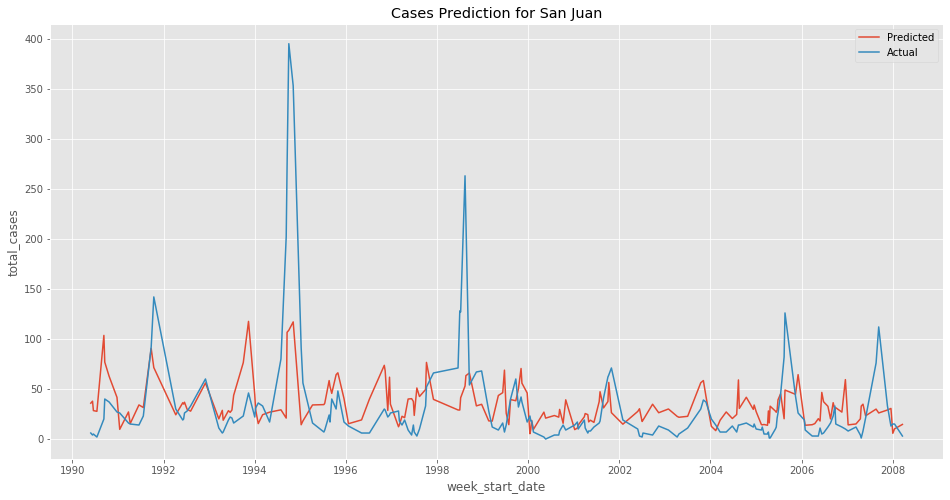

In [45]:
sj_predicted_counts = sj_pred_summary_frame['mean']

sj_actual_counts = y_sj_test_poisson['total_cases']

fig, ax = plt.subplots(figsize=(16,8))

sns.lineplot(X_sj_test_poisson.index, sj_predicted_counts, ax=ax, label='Predicted')
sns.lineplot(X_sj_test_poisson.index, sj_actual_counts,ax=ax, label='Actual')
plt.title('Cases Prediction for San Juan')
plt.legend()
plt.show()

#### This seems to work much better than the LinearRegression model. Nonetheless, it is not the most accurate.

[Pearson Chi Squared Table](https://www.medcalc.org/manual/chi-square-table.php)

[Pearson Chi Squared Info](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)

[Pearson Chi Squared Calculator](https://www.danielsoper.com/statcalc/calculator.aspx?id=12)

#### To make a determination of the accuracy using p=0.05 (for a 95% confidence level) I used the Pearson Chi Squared calculator shown above and use DF Residuals=739. The chi squared value is 803 which is smaller than what we got (28,800). What this means is that my fit is not as accurate as I would wish.

Note: These values change whenever I rerun the script

# Attempting a Negative Binomial Model (for SJ)

#### Since I already have a poisson model of the San Juan data, I can easily create a Negative Binomial Model

In [46]:
sj_poisson_training_result.mu

array([ 16.3375529 ,  23.41531125,  30.96311275,  29.47494746,
        22.86313587,  61.96626666,  59.70264125,  30.93096822,
        31.79353474,  58.04553532,  39.95831263,  47.30211524,
        51.52843586,  59.78930259,  34.0746222 ,  76.30969512,
        62.76749299,  42.88539253,  51.76582123,  51.86428573,
        94.41578641, 120.325419  ,  68.41142903,  53.75728025,
        38.82721544,  77.031944  ,  82.83767917,  15.51713185,
         4.10307974,  15.46054281,  10.26430723,  10.020314  ,
        21.96218549,  33.88338914,  30.28634895,  17.91797959,
        34.68246451,  29.42663429,  13.83878509,  21.88449131,
        30.22264898,  23.58704134,  33.83513382,  14.40635156,
        48.65349928,  42.56165285,  36.42241473,  33.56609958,
        45.22579748,  49.54131215,  42.20405751,  43.00610703,
        25.658644  ,  45.89153021,  36.25392359,  58.20291696,
        31.48274175,  71.61257567,  74.04584584,  62.57404943,
        72.55582172,  68.15506149,  52.78815749,  56.52

In [47]:
len(sj_poisson_training_result.mu)

746

In [48]:
sj_train_poisson['cases_lambda'] = sj_poisson_training_result.mu

In [49]:
sj_train_poisson.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,set_type,cases_lambda
week_start_date,,,,,,,,,,,,,,,,,,,,,
1990-04-30,sj,1990,18,1990-04-30,-0.052787,-0.193201,-0.069609,-0.284390,-0.751345,-0.830624,...,-1.792727,-0.655061,25.442857,6.900000,29.4,20.0,16.0,4.0,train,16.337553
1990-05-07,sj,1990,19,1990-05-07,0.275463,0.115456,-0.548334,-0.543272,-0.504407,-0.370095,...,-0.913462,-0.727664,26.714286,6.371429,31.7,22.2,8.6,5.0,train,23.415311
1990-05-14,sj,1990,20,1990-05-14,-0.679794,0.362636,-0.616673,-0.363628,-0.226128,0.040980,...,0.040614,-0.747831,26.714286,6.485714,32.2,22.8,41.4,4.0,train,30.963113
1990-05-21,sj,1990,21,1990-05-21,-0.010918,0.941419,0.315661,0.397224,-0.681538,0.189338,...,-0.072989,-0.711530,27.471429,6.771429,33.3,23.3,4.0,3.0,train,29.474947
1990-06-04,sj,1990,23,1990-06-04,0.457978,0.377755,0.670233,-0.236123,-0.818778,0.652958,...,0.276131,-0.804299,28.114286,6.942857,34.4,23.9,39.1,2.0,train,22.863136


In [50]:
sj_train_poisson['aux_ols_dep'] = sj_train_poisson.apply(lambda x: 
                                                         ((x['total_cases']-x['cases_lambda'])**2 -
                                                         x['total_cases'])/x['cases_lambda'],axis=1)

In [51]:
sj_train_poisson.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,set_type,cases_lambda,aux_ols_dep
week_start_date,,,,,,,,,,,,,,,,,,,,,
1990-04-30,sj,1990,18,1990-04-30,-0.052787,-0.193201,-0.069609,-0.284390,-0.751345,-0.830624,...,-0.655061,25.442857,6.900000,29.4,20.0,16.0,4.0,train,16.337553,9.072057
1990-05-07,sj,1990,19,1990-05-07,0.275463,0.115456,-0.548334,-0.543272,-0.504407,-0.370095,...,-0.727664,26.714286,6.371429,31.7,22.2,8.6,5.0,train,23.415311,14.269453
1990-05-14,sj,1990,20,1990-05-14,-0.679794,0.362636,-0.616673,-0.363628,-0.226128,0.040980,...,-0.747831,26.714286,6.485714,32.2,22.8,41.4,4.0,train,30.963113,23.350671
1990-05-21,sj,1990,21,1990-05-21,-0.010918,0.941419,0.315661,0.397224,-0.681538,0.189338,...,-0.711530,27.471429,6.771429,33.3,23.3,4.0,3.0,train,29.474947,23.678510
1990-06-04,sj,1990,23,1990-06-04,0.457978,0.377755,0.670233,-0.236123,-0.818778,0.652958,...,-0.804299,28.114286,6.942857,34.4,23.9,39.1,2.0,train,22.863136,18.950613


In [52]:
ols_expr = """aux_ols_dep ~ cases_lambda - 1"""

sj_aux_oslr_results = smf.ols(ols_expr, sj_train_poisson).fit()

In [53]:
sj_aux_oslr_results.params

cases_lambda    0.87337
dtype: float64

In [54]:
sj_aux_oslr_results.tvalues

cases_lambda    7.210453
dtype: float64

[Tvalue Calculator](https://goodcalculators.com/student-t-value-calculator/)

#### Using the t-value calculator of aroundDF Residual = 750 and the coefficient a = 0.885, it tells me that the critical tvalue at 99% confidence level is -1.2. This is much less than the t-value seen above of 7.17 thus a=0.885 should be statistically significant.

In [55]:
sj_nb2_training_results = sm.GLM(y_sj_train_poisson, X_sj_train_poisson, 
                                family=
                                 sm.families.NegativeBinomial(alpha=
                                                              sj_aux_oslr_results.params[0])).fit()

In [56]:
sj_nb2_training_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            total_cases   No. Observations:                  746
Model:                            GLM   Df Residuals:                      726
Model Family:        NegativeBinomial   Df Model:                           19
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3279.0
Date:                Sun, 17 Nov 2019   Deviance:                       729.55
Time:                        14:44:58   Pearson chi2:                     904.
No. Iterations:                    39                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 9.6348      1.860      5.181      0.000       5.990      13.279
weekofyear                                0.0174      0.003      5.691      0.000       0.011       0.023
ndvi_ne                                   0.0265      0.062      0.426      0.670      -0.095       0.148
ndvi_nw                                   0.1600      0.066      2.415      0.016       0.030       0.290
ndvi_se                                  -0.4430      0.080     -5.565      0.000      -0.599      -0.287
ndvi_sw                                   0.3369      0.090      3.743      0.000       0.161       0.513
precipitation_amt_mm                     -0.0283      0.023     -1.228      0.219      -0.073       0.017
reanalysis_air_temp_k                     0.2992      0.628      0.477      0.634      -0.931       1.530
reanalysis_avg_temp_k                    -0.4594      0.600     -0.766      0.444      -1.635       0.717
reanalysis_dew_point_temp_k              -1.2578      0.711     -1.768      0.077      -2.652       0.137
reanalysis_max_air_temp_k                 1.0472      0.364      2.879      0.004       0.334       1.760
reanalysis_min_air_temp_k                 0.0471      0.309      0.153      0.879      -0.558       0.652
reanalysis_precip_amt_kg_per_m2          -0.0051      0.058     -0.089      0.929      -0.119       0.109
reanalysis_sat_precip_amt_mm             -0.0283      0.023     -1.228      0.219      -0.073       0.017
reanalysis_specific_humidity_g_per_kg     1.6659      0.752      2.215      0.027       0.192       3.140
reanalysis_tdtr_k                        -1.4700      0.445     -3.305      0.001      -2.342      -0.598
station_avg_temp_c                       -0.3017      0.119     -2.538      0.011      -0.535      -0.069
station_diur_temp_rng_c                   0.1802      0.075      2.406      0.016       0.033       0.327
station_max_temp_c                        0.0108      0.061      0.178      0.858      -0.108       0.130
station_min_temp_c                       -0.0149      0.073     -0.205      0.838      -0.158       0.128
station_precip_mm                        -0.0023      0.002     -1.412      0.158      -0.005       0.001
=========================================================================================================
"""

In [57]:
sj_nb2_pred = sj_nb2_training_results.get_prediction(X_sj_test_poisson)

In [58]:
sj_nb2_pred_summary_frame = sj_nb2_pred.summary_frame()
sj_nb2_pred_summary_frame

,mean,mean_se,mean_ci_lower,mean_ci_upper
week_start_date,,,,
1990-05-28,32.566444,5.247214,23.747719,44.660005
1990-06-11,37.402592,3.685431,30.833962,45.370554
1990-06-18,34.596190,7.447885,22.687216,52.756425
1990-07-16,33.434041,4.671841,25.424233,43.967308
1990-09-10,123.483017,28.908686,78.042632,195.381103
...,...,...,...,...
2007-11-19,30.484302,2.875067,25.339431,36.673778
2007-12-17,26.953592,5.188559,18.482494,39.307256
2008-01-01,6.564607,1.534094,4.152313,10.378329


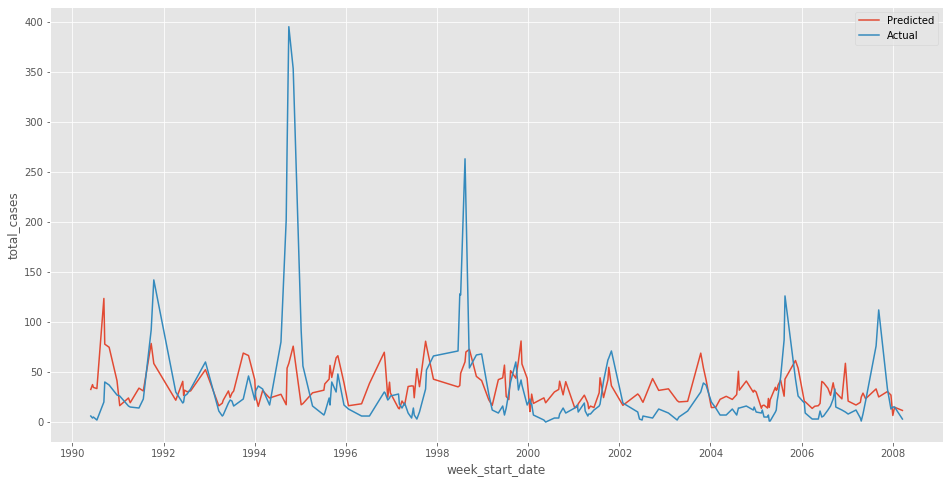

In [59]:
sj_nb2_predicted_counts=sj_nb2_pred_summary_frame['mean']

fig, ax = plt.subplots(figsize=(16,8))

sns.lineplot(X_sj_test_poisson.index,sj_nb2_predicted_counts, label='Predicted')
sns.lineplot(X_sj_test_poisson.index,sj_actual_counts, label='Actual')

plt.legend()
plt.show()

#### The plot seems to only show a slighly better fit, yet not much. To make sure of this I did the same steps as before:

[Pearson Chi Squared Calculator](https://www.danielsoper.com/statcalc/calculator.aspx?id=12)

#### The reported DF residual is 739 and the pearson chi squared is 972. Using the calculator for a 95% confidence interval (p=0.05), the result was 803.35. This is still smaller than the reported 972 and so this model is still not the best to fit our data/predict well.